# Notes 2 - Predictors of recorded DS live births

Next:

- Review data to see if we can go back further - check race
- Hyperparameter tuning
- Consider bagging vs GOSS


## Preparation


In [1]:
import duckdb, joblib, optuna, os, shap
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from lightgbm import early_stopping, log_evaluation
from scipy.spatial.distance import squareform
from scipy.cluster import hierarchy
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    average_precision_score,
    roc_auc_score,
    brier_score_loss,
    log_loss,
    precision_recall_fscore_support,
    roc_curve,
)
from sklearn.model_selection import train_test_split

from variables import Variables as vars
import repl_utils, stats_utils

pd.options.mode.copy_on_write = True

plt.style.use("../../notebook.mplstyle")

os.makedirs("./output", exist_ok=True)

RANDOM_SEED = repl_utils.RANDOM_SEED
np.random.seed(RANDOM_SEED)
rng = np.random.default_rng(RANDOM_SEED)

N_CORES = joblib.cpu_count(only_physical_cores=True)
START_TIME = datetime.now()
OUTPUT_DIR = f"output/0002-predictors/{START_TIME:%Y%m%d-%H%M%S}"

SAVE_PLOTS = True

os.makedirs(OUTPUT_DIR, exist_ok=True)

repl_utils.print_environment_info()

print(f"\n--------------------\nOutput directory: {OUTPUT_DIR}\n--------------------\n")

-------------------- Environment Information --------------------
date: 2025-12-20T20:18:34.814169
platform: Windows-11-10.0.26220-SP0
platform_version: 10.0.26220
cpu: Intel64 Family 6 Model 183 Stepping 1, GenuineIntel
cores: 32
physical_cores: 24
ram: 127 GB
ram_available: 102 GB
cuda: True
cuda_device_count: 1
cuda_device_0: NVIDIA GeForce RTX 4070 Ti SUPER
python: 3.13.11 | packaged by conda-forge | (main, Dec  6 2025, 11:10:00) [MSC v.1944 64 bit (AMD64)]
numpy: 2.3.5
pandas: 2.3.3
scipy: 1.16.3
sklearn: 1.8.0
pytorch: 2.9.1
pymc: 5.26.1
pytensor: 2.35.1
arviz: 0.23.0

--------------------
Output directory: output/0002-predictors/20251220-201834
--------------------



### Options


In [ ]:
START_YEAR = 2005
# LightGBM threads
NUM_THREADS = N_CORES
# Splitting data for training, validation and calibration
TRAINING_SPLIT = 0.5
VALIDATION_SPLIT = 0.25
CALIBRATION_SPLIT = 1 - TRAINING_SPLIT - VALIDATION_SPLIT
#
NUM_BOOST_ROUND = 5000  # 10000
EARLY_STOPPING_ROUNDS = 10  # 50
# True to search for hyperparameters
SELECT_HYPERPARAMETERS = False  # True
#
OPTIMIZE_TRIALS = 50

### Load data


In [3]:
con = duckdb.connect("./data/us_births.db", read_only=True)

df = con.execute(
    f"""
    SELECT
        -- (training label) indicated if C or P, not indicated if N, U and missing excluded from training
        CASE
            WHEN COALESCE (ca_down, ca_downs) = 'C' THEN 1::UTINYINT
            WHEN COALESCE (ca_down, ca_downs) = 'P' THEN 1::UTINYINT
            WHEN COALESCE (ca_down, ca_downs) = 'N' THEN 0::UTINYINT
            WHEN uca_downs = 1 THEN 1::UTINYINT
            WHEN uca_downs = 2 THEN 0::UTINYINT
            ELSE NULL
        END AS ca_down_c_p_n,        
        -- ==================== date of birth ====================
        year,
        -- month of birth
        dob_mm,
        -- day of week of birth (1-7)
        dob_wk,
        -- ==================== birth location ====================
        -- birth place (1: hospital, 2: not hospital, 3: unknown/not stated)
        bfacil3,
        -- ==================== characteristics of baby ====================
        -- sex of baby
        CASE
            WHEN sex = 'M' THEN 1::UTINYINT
            WHEN sex = 'F' THEN 0::UTINYINT
            ELSE NULL
        END AS sex,
        -- birth weight (grams)
        CASE
            WHEN dbwt >= 227 AND dbwt <= 8165 THEN dbwt
            -- we ignore "Not stated" as we treat this variable as numeric rather than categorical
            ELSE NULL
        END AS dbwt,
        -- ==================== characteristics of pregnancy ====================
        -- plurality (1: single... 4 quadpruplet or higher)
        dplural,
        -- month prenatal care began (1 to 10, 0: no prenatal care)
        CASE
            WHEN precare >= 0 AND precare <= 10 THEN precare
            WHEN precare = 99 THEN precare
            ELSE NULL
        END AS precare,
        -- combined gestation estimate
        CASE
            WHEN gestrec10 >= 1 AND gestrec10 <= 10 THEN gestrec10
            WHEN gestrec10 = 99 THEN gestrec10
            ELSE NULL
        END AS gestrec10,
        -- pre-pregnancy weight recode (in pounds)
        CASE
            WHEN pwgt_r >= 75 AND pwgt_r <= 375 THEN pwgt_r
            -- we ignore "Unknown or not stated" as we treat this variable as numeric rather than categorical
            ELSE NULL
        END AS pwgt_r,
        -- weight gain in pounds (98 = 98+)
        CASE
            WHEN wtgain >= 0 AND wtgain <= 98 THEN wtgain
            -- we ignore "Unknown or not stated" as we treat this variable as numeric rather than categorical
            ELSE NULL
        END AS wtgain,
        -- maternal body mass index
        CASE
            WHEN bmi >= 13.0 AND bmi < 69.9 THEN bmi
            -- we ignore "Unknown or not stated" as we treat this variable as numeric rather than categorical
            ELSE NULL
        END
        AS bmi,
        -- ==================== pregnancy risk factors ====================
        -- pre-pregnancy diabetes
        CASE
            WHEN rf_pdiab = 'Y' THEN 1::UTINYINT
            WHEN rf_pdiab = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS rf_pdiab,
        -- gestational diabetes
        CASE
            WHEN rf_gdiab = 'Y' THEN 1::UTINYINT
            WHEN rf_gdiab = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS rf_gdiab,
        -- pre-pregnancy hypertension
        CASE
            WHEN rf_phype = 'Y' THEN 1::UTINYINT
            WHEN rf_phype = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS rf_phype,
        -- gestational hypertension
        CASE
            WHEN rf_ghype = 'Y' THEN 1::UTINYINT
            WHEN rf_ghype = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS rf_ghype,
        -- hypertension eclampsia
        CASE
            WHEN rf_ehype = 'Y' THEN 1::UTINYINT
            WHEN rf_ehype = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS rf_ehype,
        -- previous preterm birth
        CASE
            WHEN rf_ppterm = 'Y' THEN 1::UTINYINT
            WHEN rf_ppterm = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS rf_ppterm,
        -- infertility treatment used
        CASE
            WHEN rf_inftr = 'Y' THEN 1::UTINYINT
            WHEN rf_inftr = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS rf_inftr,
        -- fertility enhancing drugs
        CASE
            WHEN rf_fedrg = 'Y' THEN 1::UTINYINT
            WHEN rf_fedrg = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS rf_fedrg,
        -- asst. reproductive technology
        CASE
            WHEN rf_artec = 'Y' THEN 1::UTINYINT
            WHEN rf_artec = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS rf_artec,
        -- no risk factors reported
        CASE
            WHEN no_risks <= 1 THEN no_risks
            ELSE NULL
        END AS no_risks,
        -- ==================== labor and delivery ====================
        -- induction of labor
        CASE
            WHEN ld_indl = 'Y' THEN 1::UTINYINT
            WHEN ld_indl = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ld_indl,
        -- augmentation of labor
        CASE
            WHEN ld_augm = 'Y' THEN 1::UTINYINT
            WHEN ld_augm = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ld_augm,
        -- fetal presentation at delivery
        CASE
            WHEN me_pres >= 1 AND me_pres <= 3 THEN me_pres
            WHEN me_pres = 9 THEN me_pres
            ELSE NULL
        END AS me_pres,
        -- delivery method recode
        CASE
            WHEN dmeth_rec >= 1 AND dmeth_rec <= 2 THEN dmeth_rec
            WHEN dmeth_rec = 9 THEN dmeth_rec
            ELSE NULL
        END AS dmeth_rec,
        -- ==================== newborn health ====================
        -- five minute apgar score
        CASE
            WHEN apgar5 >= 10 AND apgar5 <= 10 THEN apgar5
            WHEN apgar5 = 99 THEN apgar5
            ELSE NULL
        END AS apgar5,
        -- ten minute apgar score
        CASE
            WHEN apgar10 >= 10 AND apgar10 <= 10 THEN apgar10
            WHEN apgar10 = 99 THEN apgar10
            ELSE NULL
        END AS apgar10,
        -- assisted ventilation (immediately)
        CASE
            WHEN ab_aven1 = 'Y' THEN 1::UTINYINT
            WHEN ab_aven1 = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ab_aven1,
        -- assisted ventilation > 6 hrs
        CASE
            WHEN ab_aven6 = 'Y' THEN 1::UTINYINT
            WHEN ab_aven6 = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ab_aven6,
        -- admitted to nicu
        CASE
            WHEN ab_nicu = 'Y' THEN 1::UTINYINT
            WHEN ab_nicu = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ab_nicu,
        -- surfactant
        CASE
            WHEN ab_surf = 'Y' THEN 1::UTINYINT
            WHEN ab_surf = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ab_surf,
        -- antibiotics for newborn
        CASE
            WHEN ab_anti = 'Y' THEN 1::UTINYINT
            WHEN ab_anti = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ab_anti,
        -- seizures
        CASE
            WHEN ab_seiz = 'Y' THEN 1::UTINYINT
            WHEN ab_seiz = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ab_seiz,
        -- no_abnorm
        CASE
            WHEN no_abnorm >= 0 AND no_abnorm <= 1 THEN no_abnorm
            WHEN no_abnorm = 9 THEN no_abnorm
            ELSE NULL
        END AS no_abnorm,
        -- ==================== identified disorders ====================
        -- congenital disorder
        CASE
            WHEN ca_disor = 'C' THEN 1::UTINYINT
            WHEN ca_disor = 'P' THEN 2::UTINYINT
            WHEN ca_disor = 'N' THEN 0::UTINYINT
            ELSE NULL
        END
        AS ca_disor,
        -- anencephaly
        CASE
            WHEN ca_anen = 'Y' THEN 1::UTINYINT
            WHEN ca_anen = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_anen,
        -- meningomyelocele / spina bifida
        CASE
            WHEN ca_mnsb = 'Y' THEN 1::UTINYINT
            WHEN ca_mnsb = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_mnsb,
        -- congenital heart defect
        CASE
            WHEN ca_cchd = 'Y' THEN 1::UTINYINT
            WHEN ca_cchd = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_cchd,
        -- ca_cdh
        CASE
            WHEN ca_cdh = 'Y' THEN 1::UTINYINT
            WHEN ca_cdh = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_cdh,
        -- omphalocele
        CASE
            WHEN ca_omph = 'Y' THEN 1::UTINYINT
            WHEN ca_omph = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_omph,
        -- gastroschisis
        CASE
            WHEN ca_gast = 'Y' THEN 1::UTINYINT
            WHEN ca_gast = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_gast,
        -- limb reduction defect
        CASE
            WHEN ca_limb = 'Y' THEN 1::UTINYINT
            WHEN ca_limb = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_limb,
        -- cleft lip w/ or w/o cleft palate
        CASE
            WHEN ca_cleft = 'Y' THEN 1::UTINYINT
            WHEN ca_cleft = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_cleft,
        -- cleft palate alone
        CASE
            WHEN ca_clpal = 'Y' THEN 1::UTINYINT
            WHEN ca_clpal = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_clpal,
        -- Hypospadias
        CASE
            WHEN ca_hypo = 'Y' THEN 1::UTINYINT
            WHEN ca_hypo = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_hypo,
        -- suspected chromosomal disorder
        CASE
            WHEN ca_disor = 'C' THEN 1::UTINYINT
            WHEN ca_disor = 'P' THEN 2::UTINYINT
            WHEN ca_disor = 'N' THEN 0::UTINYINT
            WHEN ca_disor = 'U' THEN 9::UTINYINT
            ELSE NULL
        END AS ca_disor,
        -- no_congen
        CASE
            WHEN no_congen >= 0 AND no_congen <= 1 THEN no_congen
            WHEN no_congen = 9 THEN no_congen
            ELSE NULL
        END AS no_congen,
        -- ==================== maternal characteristics ====================
        -- maternal age in years
        mage_c,
        -- maternal education
        CASE
            WHEN meduc >= 0 AND meduc < 10 THEN meduc
            ELSE NULL
        END AS meduc,
        -- maternal race
        CASE
            WHEN  mracehisp >= 1 AND mracehisp <= 8 THEN mracehisp
            ELSE NULL
        END AS mracehisp,
        -- ==================== paternal characteristics ====================
        -- father's combined age in years
        CASE
            WHEN fagecomb >= 9 AND fagecomb < 99 THEN fagecomb
            ELSE NULL
        END AS fagecomb,
        -- paternal education
        CASE
            WHEN  feduc < 9 THEN feduc
            ELSE NULL
        END AS feduc,
        -- paternal race
        CASE
            WHEN  fracehisp >= 1 AND fracehisp <= 10 THEN fracehisp
            ELSE NULL
        END AS fracehisp,
        -- ==================== socio-economic indicators ====================
        -- payment source recode
        CASE
            WHEN  pay_rec < 5 THEN pay_rec
            ELSE NULL
        END AS pay_rec,
        -- supplemental nutrition program for women, infants, and children
        CASE
            WHEN wic = 'Y' THEN 1::UTINYINT
            WHEN wic = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS wic
    FROM
        us_births
    WHERE year >= {START_YEAR} AND ca_down_c_p_n IS NOT NULL
    ORDER BY
        year, dob_mm, dob_wk
    """
).df()

con.close()

df.describe().T

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,count,mean,std,min,25%,50%,75%,max
ca_down_c_p_n,78161818.0,0.000508,0.022542,0.0,0.0,0.0,0.0,1.0
year,78161818.0,2014.217173,5.753869,2005.0,2009.0,2014.0,2019.0,2024.0
dob_mm,78161818.0,6.571835,3.418064,1.0,4.0,7.0,9.0,12.0
dob_wk,78161818.0,4.054011,1.842688,1.0,3.0,4.0,6.0,7.0
dob_tt,5036326.0,124.140967,82.185313,0.0,42.0,125.0,210.0,255.0
bfacil3,78161818.0,1.015354,0.123327,1.0,1.0,1.0,1.0,3.0
sex,78161818.0,0.511585,0.499866,0.0,0.0,1.0,1.0,1.0
dbwt,78100022.0,3261.827446,589.739979,227.0,2963.0,3300.0,3629.0,8165.0
dplural,78161098.0,1.034702,0.189742,1.0,1.0,1.0,1.0,4.0
precare,63370803.0,2.968378,1.54624,0.0,2.0,3.0,3.0,10.0


In [ ]:
def score_metrics(y_true, p_valid):
    """
    Compute validation metrics: AUC, AP, log loss, ROC curve.

    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        True binary labels.
    p_valid : array-like of shape (n_samples,)
        Predicted probabilities or scores.

    Returns
    -------
    p_valid_auc : float
        Area Under the ROC Curve.
    p_valid_ap : float
        Average Precision score.
    p_valid_ll : float
        Log loss.
    p_valid_fpr : array-like of shape (n_thresholds,)
        False Positive Rates for ROC curve.
    p_valid_tpr : array-like of shape (n_thresholds,)
        True Positive Rates for ROC curve.
    p_valid_thresholds : array-like of shape (n_thresholds,)
        Thresholds used to compute ROC curve.
    """
    p_valid_auc = roc_auc_score(y_true, p_valid)
    p_valid_ap = average_precision_score(y_true, p_valid)
    p_valid_ll = log_loss(y_true, p_valid, labels=[0, 1])
    p_valid_fpr, p_valid_tpr, p_valid_thresholds = roc_curve(y_true, p_valid)
    return (
        p_valid_auc,
        p_valid_ap,
        p_valid_ll,
        p_valid_fpr,
        p_valid_tpr,
        p_valid_thresholds,
    )


def precision_recall_at_k(y_true, p_valid, K: int = 10000):
    """
    Compute precision and recall at top K predictions.

    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        True binary labels.
    p_valid : array-like of shape (n_samples,)
        Predicted probabilities or scores.
    K : int
        Number of top predictions to consider.

    Returns
    -------
    precision_at_k : float
        Precision at top K predictions.
    recall_at_k : float
        Recall at top K predictions.
    """
    order = np.argsort(-p_valid)
    y_sorted = y_true.to_numpy()[order]
    precision_at_k = y_sorted[:K].mean()
    recall_at_k = y_sorted[:K].sum() / y_true.sum()
    return precision_at_k, recall_at_k


def precision_recall_at_threshold(y_true, p_valid, thr: float = 0.01):
    """
    Compute precision and recall at a given threshold.

    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        True binary labels.
    p_valid : array-like of shape (n_samples,)
        Predicted probabilities or scores.
    thr : float
        Threshold for converting predicted probabilities to binary predictions.

    Returns
    -------
    prec : float
        Precision at the given threshold.
    rec : float
        Recall at the given threshold.
    f1 : float
        F1-score at the given threshold.
    """
    y_hat = (p_valid >= thr).astype(int)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_hat, average="binary")
    return prec, rec, f1


def get_metrics(y_true, p_valid, K: int = 10000, thr: float = 0.01):
    """
    Build a DataFrame of validation metrics.

    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        True binary labels.
    p_valid : array-like of shape (n_samples,)
        Predicted probabilities or scores.
    K : int
        Number of top predictions to consider for precision/recall at K.
    thr : float
        Threshold for precision/recall calculation.
    Returns
    -------
    metrics_df : pd.DataFrame
        DataFrame containing validation metrics.
    """

    (
        p_valid_auc,
        p_valid_ap,
        p_valid_ll,
        p_valid_fpr,
        p_valid_tpr,
        p_valid_thresholds,
    ) = score_metrics(y_true, p_valid)

    precision_at_k, recall_at_k = precision_recall_at_k(y_true, p_valid, K=K)
    
    prec, rec, f1 = precision_recall_at_threshold(y_true, p_valid, thr=thr)

    df = pd.DataFrame(
        {
            "metric": [
                "Validation AUC",
                "Validation AP",
                "Validation log loss",
                f"Precision at {K}",
                f"Recall at {K}",
                f"Precision (threshold={thr})",
                f"Recall (threshold={thr})",
            ],
            "value": [
                p_valid_auc,
                p_valid_ap,
                p_valid_ll,
                precision_at_k,
                recall_at_k,
                prec,
                rec,
            ],
        }
    )

    return df, p_valid_fpr, p_valid_tpr, p_valid_thresholds

### Define initial feature set


In [4]:
numeric = [
    "year",
    "dbwt",
    "pwgt_r",
    "wtgain",
    "bmi",
    "mage_c",
    "fagecomb",
]

categorical = [
    "dob_mm",
    "dob_wk",
    "bfacil3",
    "sex",
    "precare",
    "gestrec10",
    "rf_pdiab",
    "rf_gdiab",
    "rf_phype",
    "rf_ghype",
    "rf_ehype",
    "rf_ppterm",
    "rf_inftr",
    "rf_fedrg",
    "rf_artec",
    "no_risks",
    "ld_indl",
    "ld_augm",
    "me_pres",
    "dmeth_rec",
    "apgar5",
    "apgar10",
    "ab_aven1",
    "ab_aven6",
    "ab_nicu",
    "ab_surf",
    "ab_anti",
    "ab_seiz",
    "no_abnorm",
    "ca_anen",
    "ca_mnsb",
    "ca_cchd",
    "ca_cdh",
    "ca_omph",
    "ca_gast",
    "ca_limb",
    "ca_cleft",
    "ca_clpal",
    "ca_hypo",
    "ca_disor",
    "no_congen",
    "meduc",
    "mracehisp",
    "feduc",
    "fracehisp",
    "pay_rec",
    "wic",
]

features = categorical + numeric

X = df[features]
y = df["ca_down_c_p_n"]

X[categorical] = X[categorical].astype("category")

### Split training, validation and calibration data


In [ ]:
# use half the data for the training set
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=TRAINING_SPLIT, stratify=y, random_state=RANDOM_SEED
)

# use a quarter of the data for training validation and a quarter for calibration
X_valid, X_cal, y_valid, y_cal = train_test_split(
    X_tmp,
    y_tmp,
    test_size=(VALIDATION_SPLIT / TRAINING_SPLIT),
    stratify=y_tmp,
    random_state=RANDOM_SEED,
)

train_data = lgb.Dataset(
    X_train, label=y_train, categorical_feature=categorical, free_raw_data=False
)

valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=categorical,
    reference=train_data,
    free_raw_data=False,
)

In [6]:
neg_count_train = y_train[y_train == 0].count()
pos_count_train = y_train[y_train == 1].count()
# scale_pos_weight = neg_count_train / pos_count_train

neg_count_valid = y_valid[y_valid == 0].count()
pos_count_valid = y_valid[y_valid == 1].count()

neg_count_cal = y_cal[y_cal == 0].count()
pos_count_cal = y_cal[y_cal == 1].count()

print(
    f"Training set: {neg_count_train} negatives, {pos_count_train} positives, probability positive {pos_count_train / neg_count_train:.8f}"
)
print(
    f"Validation set: {neg_count_valid} negatives, {pos_count_valid} positives, probability positive {pos_count_valid / neg_count_valid:.8f}"
)
print(
    f"Calibration set: {neg_count_cal} negatives, {pos_count_cal} positives, probability positive {pos_count_cal / neg_count_cal:.8f}"
)

Training set: 39061040 negatives, 19869 positives, probability positive 0.00050867
Validation set: 19530520 negatives, 9934 positives, probability positive 0.00050864
Calibration set: 19530521 negatives, 9934 positives, probability positive 0.00050864


In [ ]:
base_params = {
    "objective": "binary",
    "metric": ["average_precision", "binary_logloss"],
    "boosting_type": "gbdt",
    "max_bin": 255,  # GPU 63/127; CPU 255
    # for now, we do not scale for better interpretability of outputs
    "scale_pos_weight": 1,
    "force_col_wise": True,
    "seed": RANDOM_SEED,
    "num_threads": NUM_THREADS,
    "verbosity": 1,
}

last_best_params = {
    "learning_rate": 0.01829126776020476,
    "num_leaves": 102,
    "min_data_in_leaf": 534,
    "min_gain_to_split": 0.8303930021015241,
    "feature_fraction": 0.920035945804595,
    "bagging_fraction": 0.967714257064493,
    "bagging_freq": 4,
    "lambda_l1": 0.00796905087446552,
    "lambda_l2": 1.0310320881269643,
}

## Hyperparameter tuning


In [ ]:
def objective(trial):
    trial_params = {
        # required to change min_data_in_leaf across trials without rebuilding the Dataset
        "feature_pre_filter": False,
        # Speed / stability
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.5, log=True),
        # Tree complexity
        "num_leaves": trial.suggest_int("num_leaves", 32, 512, log=True),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 500, 15000, log=True),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.0, 1.0),
        # Sampling
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        # Regularization
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
    }

    # Merge: base_params always present; trial_params override if same key exists
    params = {**base_params, **trial_params}

    pruning_cb = optuna.integration.LightGBMPruningCallback(trial, "average_precision")

    gbm = lgb.train(
        params,
        train_data,
        num_boost_round=NUM_BOOST_ROUND,
        valid_sets=[valid_data],
        callbacks=[
            lgb.early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
            lgb.log_evaluation(period=10),
            pruning_cb,
        ],
    )

    # Best score on validation
    return gbm.best_score["valid_0"]["average_precision"]


if SELECT_HYPERPARAMETERS:
    study = optuna.create_study(
        direction="maximize",
        sampler=optuna.samplers.TPESampler(),
        pruner=optuna.pruners.HyperbandPruner(),
    )

    study.optimize(objective, n_trials=OPTIMIZE_TRIALS)

    print(study.best_params, study.best_value)

    best = study.best_params
else:
    best = last_best_params

# Merge (best overrides base if there are collisions)
params = {**base_params, **best}
params["feature_pre_filter"] = True  # reset to default for final training

print("Parameters for training:")
for k, v in params.items():
    print(f'  "{k}": {v}')

## Model 0 (all initial predictors)


In [9]:
model_idx = 0
model_name = f"Model {model_idx} (all initial predictors)"

gbm = lgb.train(
    params,
    train_data,
    num_boost_round=NUM_BOOST_ROUND,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[
        early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
        log_evaluation(period=10),
    ],
)

[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1178
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 50 rounds
[5]	train's average_precision: 0.547765	train's binary_logloss: 0.00247103	valid's average_precision: 0.542233	valid's binary_logloss: 0.00248483
[10]	train's average_precision: 0.54985	train's binary_logloss: 0.00233996	valid's average_precision: 0.543815	valid's binary_logloss: 0.00235695
[15]	train's average_precision: 0.551466	train's binary_logloss: 0.00225486	valid's average_precision: 0.545028	valid's binary_logloss: 0.00227429
[20]	train's average_precision: 0.552482	train's binary_logloss: 0.00219125	valid's average_precision: 0.545754	valid's binary_logloss: 0.00221283
[25]	train's av

In [10]:
best_iter = gbm.best_iteration
gbm.save_model(
    f"{OUTPUT_DIR}/model_{model_idx}_{datetime.now().strftime("%Y%m%d%H%M")}.txt",
    num_iteration=best_iter,
)
print("best_iteration:", best_iter)

best_iteration: 452


### Predict

Produce predictions on validation set


In [11]:
p_valid = gbm.predict(X_valid, num_iteration=best_iter)

### Evaluate predictions


In [12]:
p_valid_auc = roc_auc_score(y_valid, p_valid)
p_valid_ap = average_precision_score(y_valid, p_valid)
p_valid_ll = log_loss(y_valid, p_valid, labels=[0, 1])
p_valid_fpr, p_valid_tpr, p_valid_thresholds = roc_curve(y_valid, p_valid)

# Top-K precision (what fraction of the top K are truly positive?)
order = np.argsort(-p_valid)
y_sorted = y_valid.to_numpy()[order]

K = 10000
precision_at_k = y_sorted[:K].mean()
recall_at_k = y_sorted[:K].sum() / y_valid.sum()
precision_at_k, recall_at_k

# Precision/recall at a chosen threshold
thr = 0.01
y_hat = (p_valid >= thr).astype(int)
prec, rec, f1, _ = precision_recall_fscore_support(y_valid, y_hat, average="binary")
prec, rec, f1

print(f"Validation AUC:      {p_valid_auc:.4f}")
print(f"Validation AP:       {p_valid_ap:.6f}")
print(f"Validation log loss: {p_valid_ll:.6f}")

print(f"Precision at {K}: {precision_at_k}")
print(f"Recall at {K}: {recall_at_k}")
print(f"Precision (threshold={thr}): {prec}")
print(f"Recall (threshold={thr}): {rec}")

Validation AUC:      0.9660
Validation AP:       0.556099
Validation log loss: 0.001829


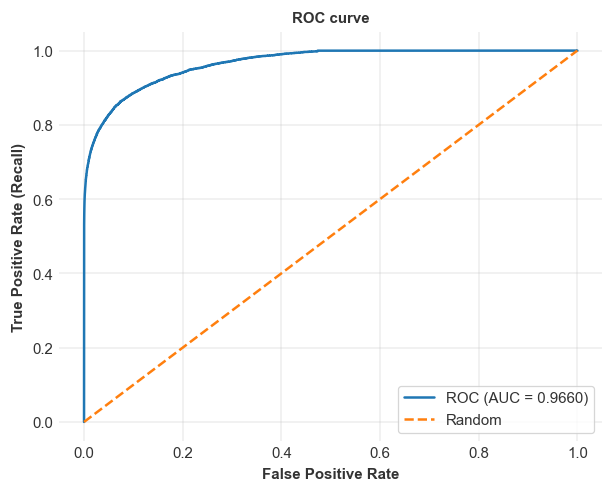

In [13]:
plt.figure(figsize=(5, 4))
plt.plot(p_valid_fpr, p_valid_tpr, label=f"ROC (AUC = {p_valid_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC curve")
plt.legend()
plt.show()

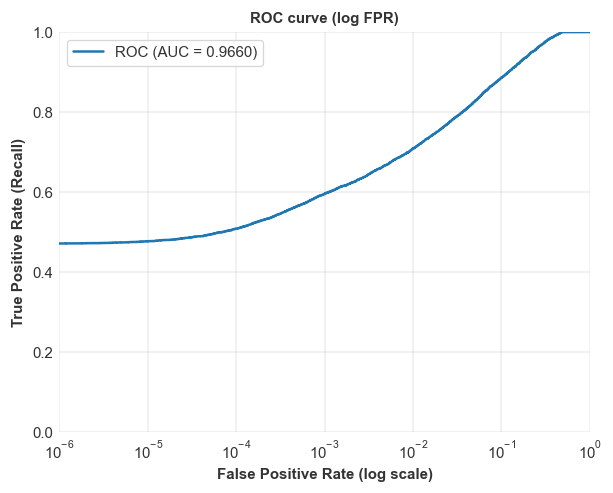

In [14]:
plt.figure(figsize=(5, 4))
plt.plot(p_valid_fpr, p_valid_tpr, label=f"ROC (AUC = {p_valid_auc:.4f})")
plt.xscale("log")
plt.xlim(1e-6, 1)  # adjust lower bound as needed
plt.ylim(0, 1)

plt.xlabel("False Positive Rate (log scale)")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC curve (log FPR)")
plt.legend()
plt.show()

#### Feature importance


In [15]:
importance_gain = gbm.feature_importance(importance_type="gain")

df_imp_gain = pd.DataFrame(
    {"feature": features, "importance_gain": importance_gain}
).sort_values("importance_gain", ascending=False)

df_imp_gain.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_feature_importance_gain_{datetime.now().strftime("%Y%m%d%H%M")}.csv",
    index=False,
)
df_imp_gain

,feature,importance_gain
40,no_congen,3.440294e+06
52,mage_c,1.909603e+06
33,ca_omph,1.094027e+06
39,ca_disor,1.015242e+06
29,ca_anen,9.644229e+05
31,ca_cchd,9.470110e+05
35,ca_limb,7.581273e+05
36,ca_cleft,6.256710e+05
32,ca_cdh,6.227639e+05
38,ca_hypo,5.382911e+05


## Evaluation subset for permutation importances and SHAP analysis


In [ ]:
y_valid_pos_idx = y_valid[y_valid == 1].index
y_valid_neg_idx = y_valid[y_valid == 0].index

n_pos_eval = min(10_000, len(y_valid_pos_idx))
n_neg_eval = min(10 * n_pos_eval, len(y_valid_neg_idx))  # 10:1 negatives:positives

rng = np.random.default_rng(123)

pos_sample = rng.choice(y_valid_pos_idx, size=n_pos_eval, replace=False)
neg_sample = rng.choice(y_valid_neg_idx, size=n_neg_eval, replace=False)

eval_idx = np.concatenate([pos_sample, neg_sample])
eval_idx = rng.permutation(eval_idx)  # shuffle

X_eval = X_valid.loc[eval_idx].astype(np.float64).replace({pd.NA: np.nan})
X_eval[categorical] = X_eval[categorical].astype("category")

y_eval = y_valid.loc[eval_idx]

In [ ]:
def ap_scorer(estimator, X, y):
    proba = estimator.predict_proba(X)[:, 1]
    return average_precision_score(y, proba)


class LGBMWrapper:
    def __init__(self, booster):
        self.booster = booster

    def fit(self, X, y=None):
        # Required by sklearn API; we don't actually train here.
        return self

    def predict_proba(self, X):
        # LightGBM Booster.predict gives P(y=1) for binary by default
        p1 = self.booster.predict(X)
        p0 = 1.0 - p1
        return np.column_stack([p0, p1])

    def predict(self, X):
        p1 = self.booster.predict(X)
        return (p1 >= 0.5).astype(int)


model_wrapped = LGBMWrapper(gbm)

In [21]:
result = permutation_importance(
    model_wrapped,
    X_eval,
    y_eval,
    scoring=ap_scorer,
    n_repeats=10,
    n_jobs=NUM_THREADS,
    random_state=RANDOM_SEED,
)

perm_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std,
    }
).sort_values("importance_mean", ascending=False)

perm_importance.to_csv(
    f"{OUTPUT_DIR}/permutation_importance_{datetime.now().strftime("%Y%m%d%H%M")}.csv",
    index=False,
)
perm_importance

,feature,importance_mean,importance_std
40,no_congen,7.168823e-01,0.000838
24,ab_nicu,5.594721e-02,0.000421
52,mage_c,5.102084e-02,0.001264
38,ca_hypo,4.458064e-02,0.001458
36,ca_cleft,4.361752e-02,0.001170
31,ca_cchd,3.433645e-02,0.001298
39,ca_disor,2.768194e-02,0.000620
47,year,2.456687e-02,0.001340
48,dbwt,2.020600e-02,0.000609
34,ca_gast,1.852566e-02,0.000855


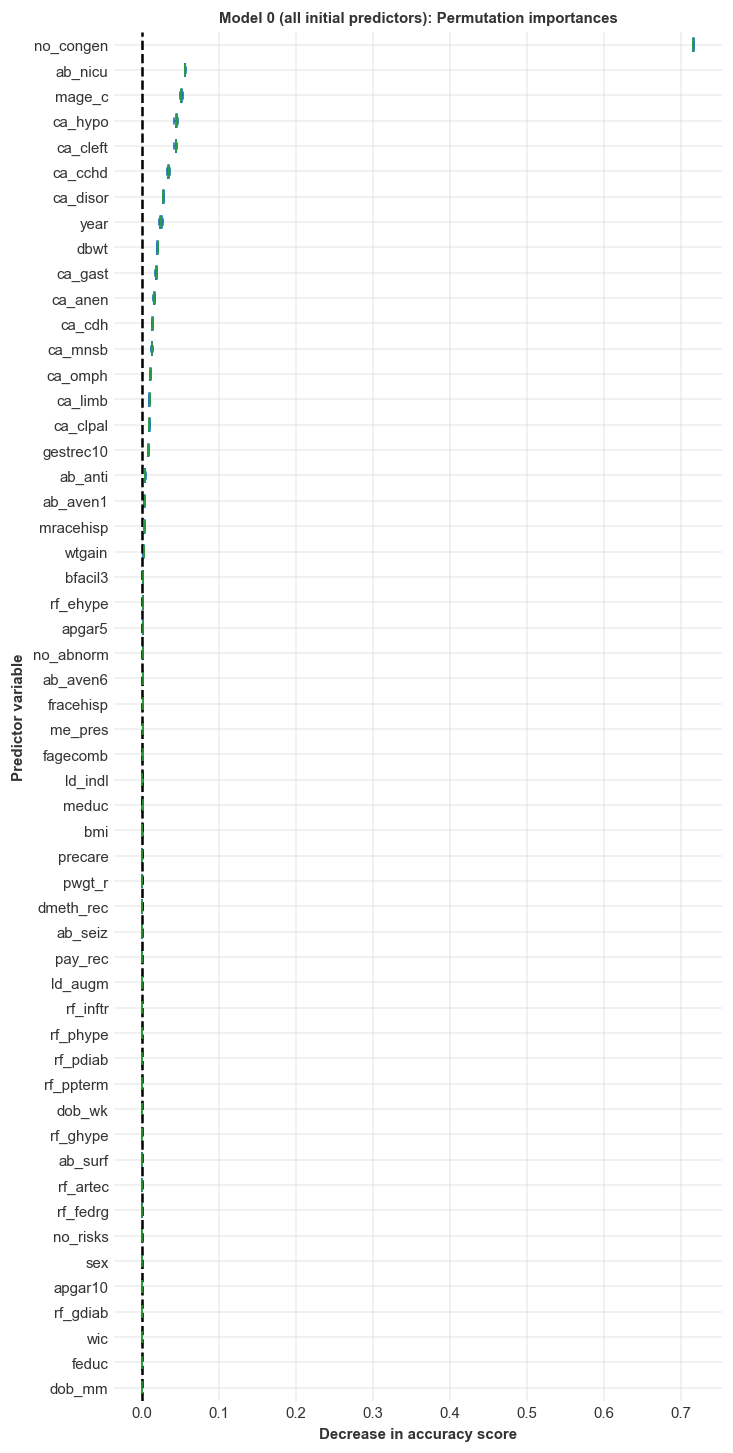

In [41]:
sorted_importances_idx_0 = result.importances_mean.argsort()

importances_0 = pd.DataFrame(
    result.importances[sorted_importances_idx_0].T,
    columns=X_eval.columns[sorted_importances_idx_0],
)

ax = importances_0.plot.box(vert=False, whis=10, figsize=(6, 12))
ax.set_title(f"{model_name}: Permutation importances")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.set_ylabel("Predictor variable")
plt.show()

In [42]:
X_eval.columns[sorted_importances_idx_0]

Index(['dob_mm', 'feduc', 'wic', 'rf_gdiab', 'apgar10', 'sex', 'no_risks',
       'rf_fedrg', 'rf_artec', 'ab_surf', 'rf_ghype', 'dob_wk', 'rf_ppterm',
       'rf_pdiab', 'rf_phype', 'rf_inftr', 'ld_augm', 'pay_rec', 'ab_seiz',
       'dmeth_rec', 'pwgt_r', 'precare', 'bmi', 'meduc', 'ld_indl', 'fagecomb',
       'me_pres', 'fracehisp', 'ab_aven6', 'no_abnorm', 'apgar5', 'rf_ehype',
       'bfacil3', 'wtgain', 'mracehisp', 'ab_aven1', 'ab_anti', 'gestrec10',
       'ca_clpal', 'ca_limb', 'ca_omph', 'ca_mnsb', 'ca_cdh', 'ca_anen',
       'ca_gast', 'dbwt', 'year', 'ca_disor', 'ca_cchd', 'ca_cleft', 'ca_hypo',
       'mage_c', 'ab_nicu', 'no_congen'],
      dtype='object')

In [ ]:
# need not NA - some columns have many NAs
distance_0, corr_0 = stats_utils.distance_corr_dissimilarity(X_eval)
condensed_0 = squareform(distance_0, checks=True)
dist_linkage_0 = hierarchy.ward(condensed_0)

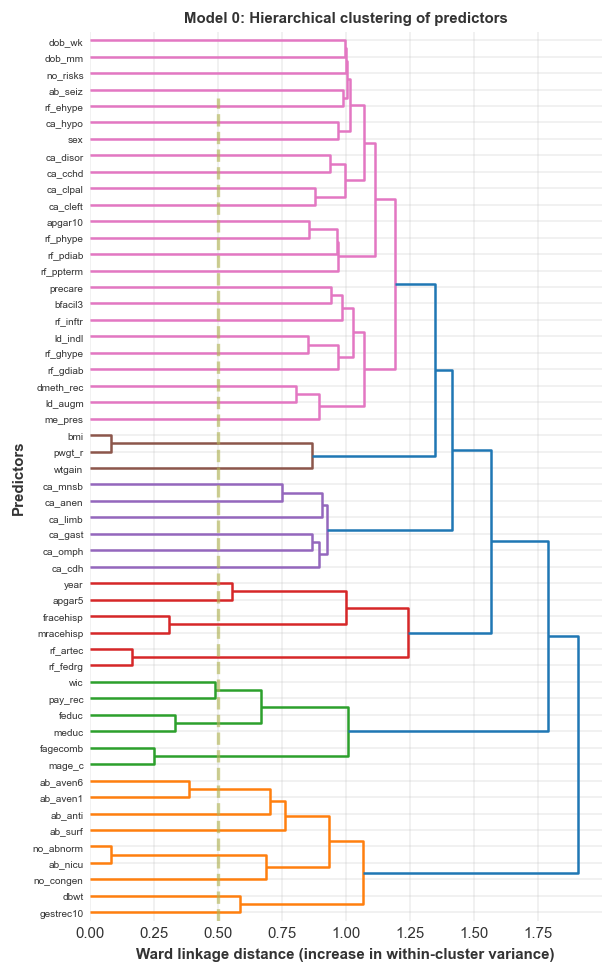

In [23]:
plt.figure(figsize=(5, 8))
dendro_0 = hierarchy.dendrogram(
    dist_linkage_0, labels=X_eval.columns.to_list(), orientation="right", ax=plt.axes()
)
plt.vlines(0.5, 0, 500, linestyle="--", color="#b2b4549f", linewidth=2)
plt.xlabel("Ward linkage distance (increase in within-cluster variance)")
plt.ylabel("Predictors")
plt.title(f"Model 0: Hierarchical clustering of predictors")
plt.show()

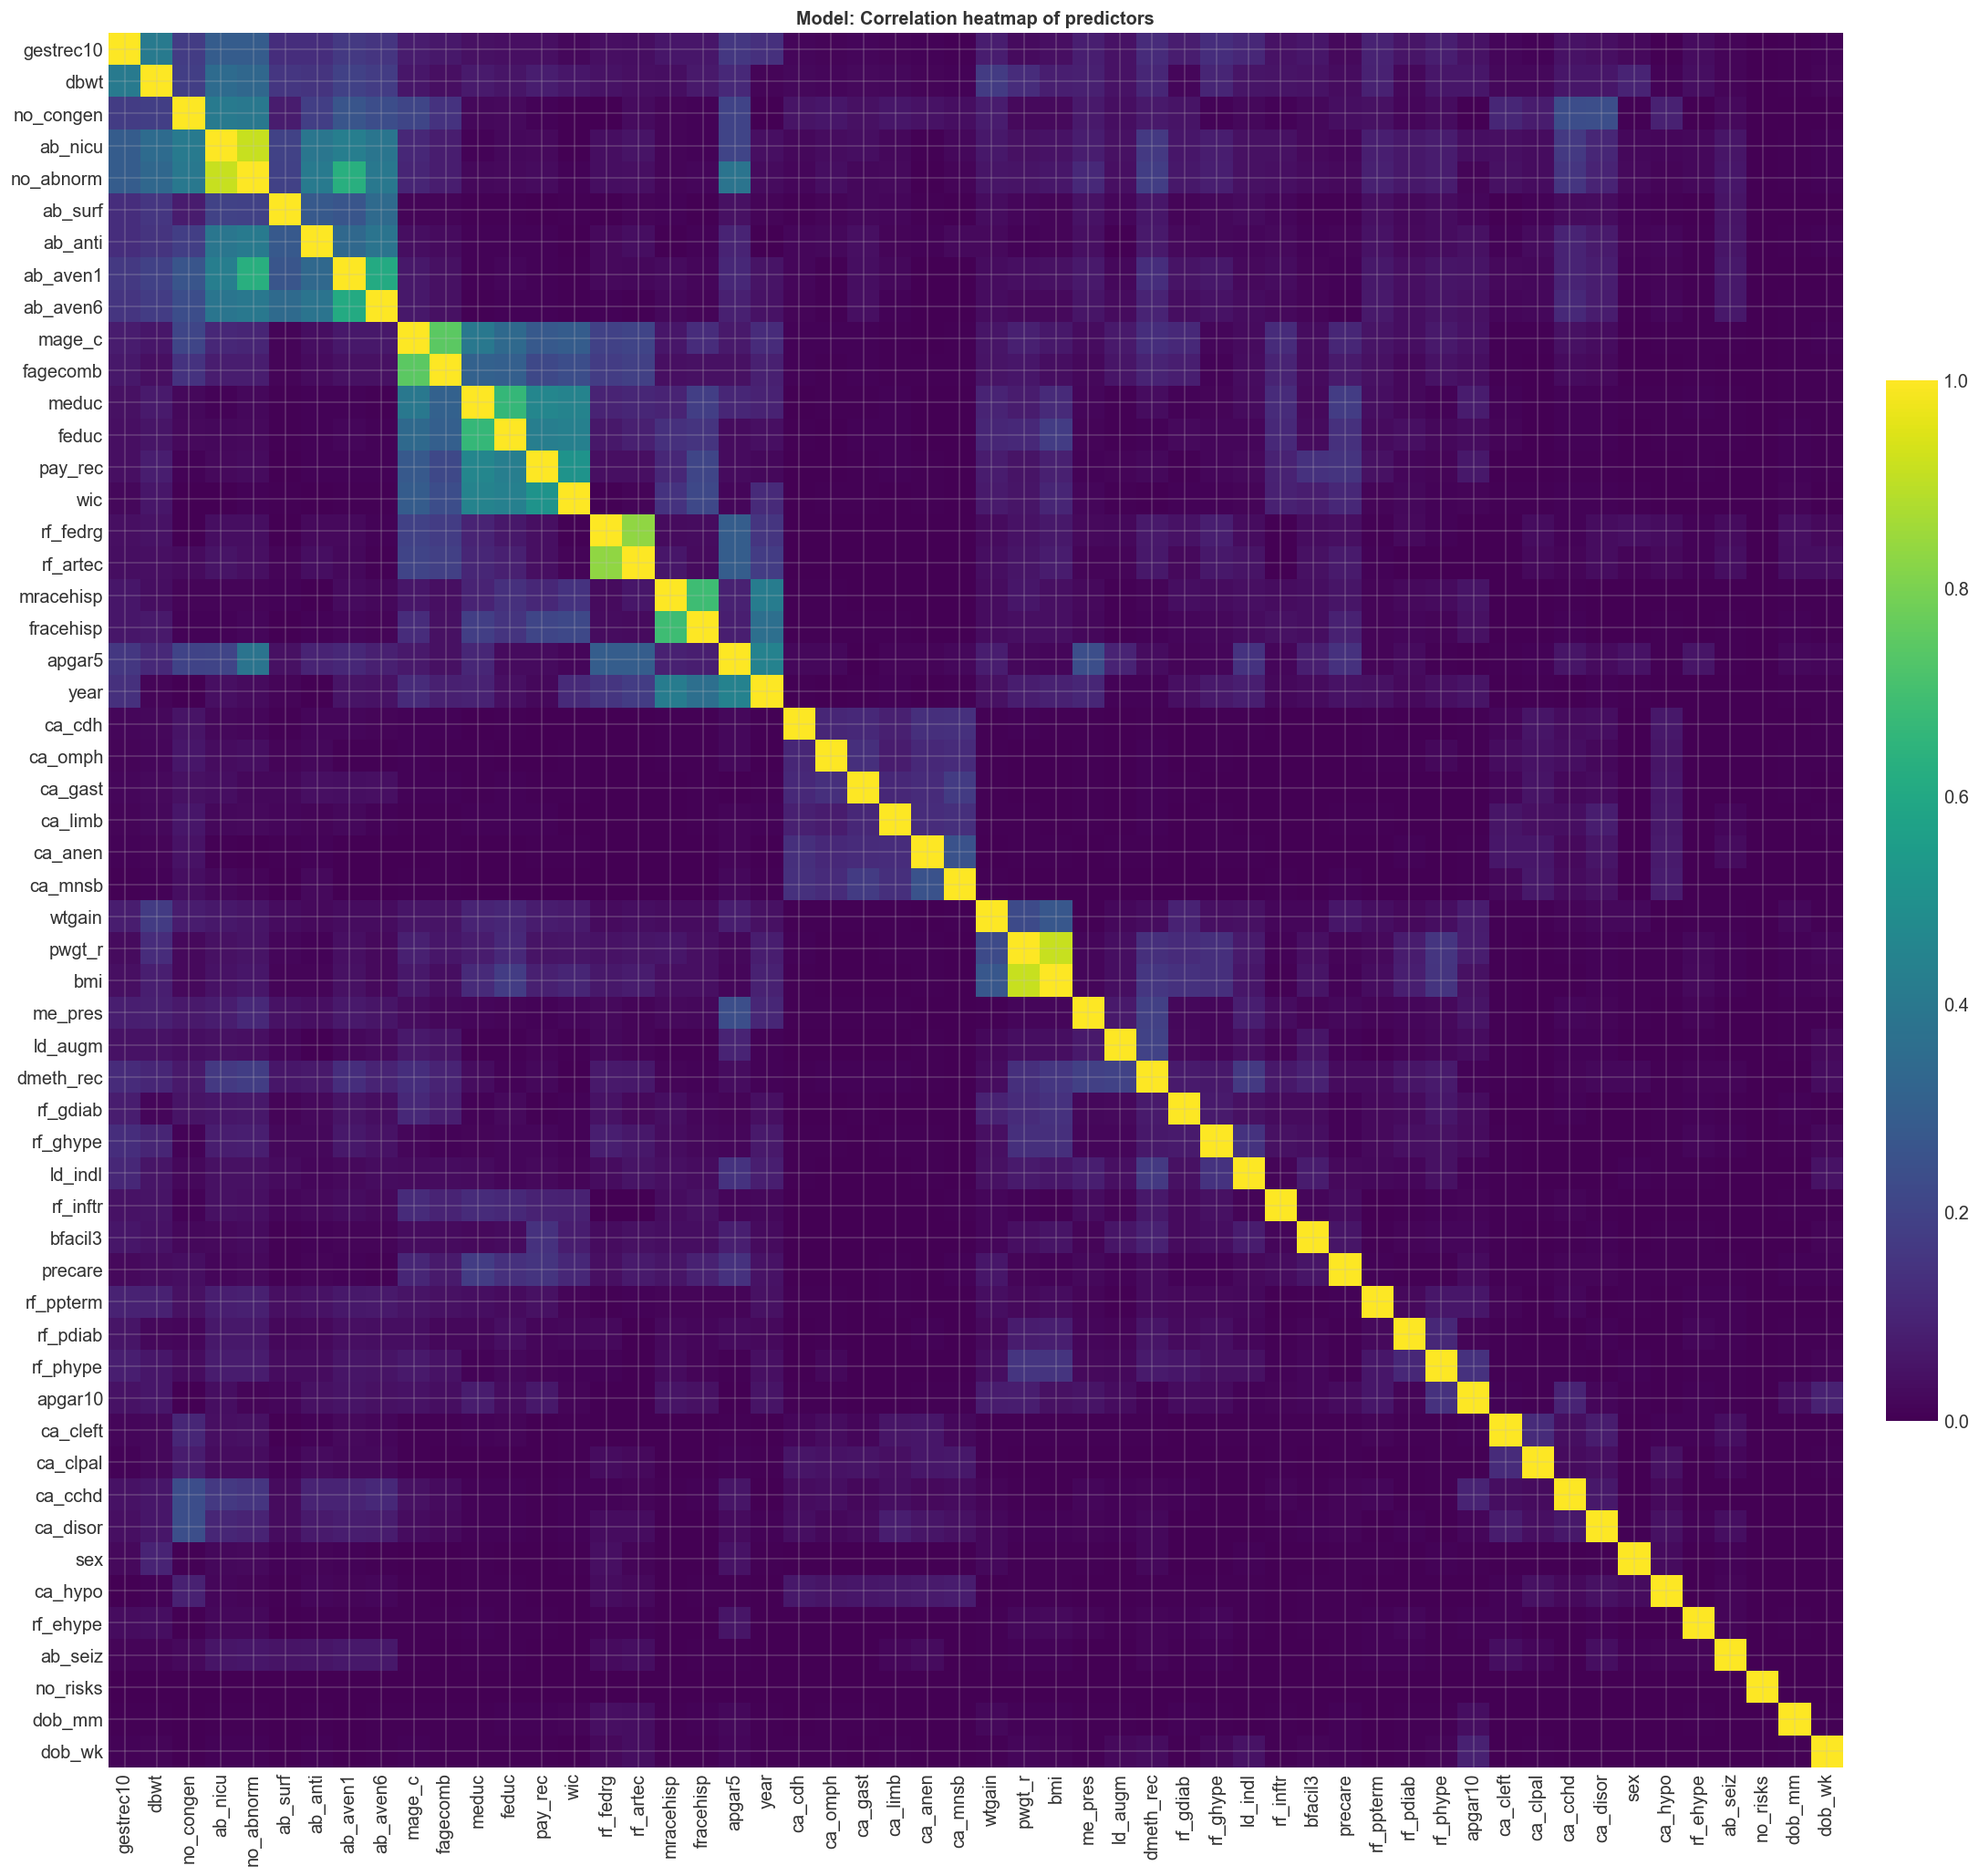

In [ ]:
dendro_0_idx = np.arange(0, len(dendro_0["ivl"]))

with plt.rc_context(
    {"ytick.labelsize": 12, "xtick.labelsize": 12, "axes.titlesize": 12}
):
    plt.figure(figsize=(18, 18))
    plt.set_cmap("viridis")
    ax = plt.axes()
    im = ax.imshow(corr_0[dendro_0["leaves"], :][:, dendro_0["leaves"]])
    ax.set_title(f"Model: Correlation heatmap of predictors")
    ax.set_xticks(dendro_0_idx)
    ax.set_yticks(dendro_0_idx)
    ax.set_xticklabels(dendro_0["ivl"], rotation="vertical")
    ax.set_yticklabels(dendro_0["ivl"])
    plt.colorbar(im, ax=ax, fraction=0.03, pad=0.025)
    plt.show()

In [25]:
# Tell SHAP this is a LightGBM model
explainer = shap.TreeExplainer(gbm)
explanation = explainer(X_eval)
clustering_0 = shap.utils.hclust(
    X_eval, y_eval, linkage="average", random_state=RANDOM_SEED
)
shap_values = explanation.values

# Handle both cases: list or array
if isinstance(shap_values, list):
    shap_pos = shap_values[1]  # SHAP values for positive class
else:
    shap_pos = shap_values  # already positive class

# Global importance: mean |SHAP|
shap_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "mean_abs_shap": np.mean(np.abs(shap_pos), axis=0),
    }
).sort_values("mean_abs_shap", ascending=False)

shap_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_shap_importance_{datetime.now().strftime("%Y%m%d%H%M")}.csv",
    index=False,
)
shap_importance

c:\Users\FrankBuckley\miniconda3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 0 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
c:\Users\FrankBuckley\miniconda3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 1 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
c:\Users\FrankBuckley\miniconda3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 2 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
c:\Users\FrankBuckley\

,feature,mean_abs_shap
40,no_congen,3.817842
52,mage_c,0.200831
24,ab_nicu,0.188744
48,dbwt,0.179994
39,ca_disor,0.121822
5,gestrec10,0.117653
31,ca_cchd,0.117179
47,year,0.108001
28,no_abnorm,0.084083
36,ca_cleft,0.058903


In [44]:
shap_importance["feature"].tolist()

['no_congen',
 'mage_c',
 'ab_nicu',
 'dbwt',
 'ca_disor',
 'gestrec10',
 'ca_cchd',
 'year',
 'no_abnorm',
 'ca_cleft',
 'ca_hypo',
 'mracehisp',
 'ca_cdh',
 'ca_mnsb',
 'ca_anen',
 'ca_omph',
 'ab_aven1',
 'ca_limb',
 'wtgain',
 'ca_clpal',
 'ca_gast',
 'ab_anti',
 'fracehisp',
 'apgar5',
 'precare',
 'meduc',
 'dob_mm',
 'dob_wk',
 'fagecomb',
 'rf_ehype',
 'bmi',
 'pwgt_r',
 'me_pres',
 'dmeth_rec',
 'bfacil3',
 'pay_rec',
 'ab_aven6',
 'ld_augm',
 'feduc',
 'ld_indl',
 'ab_surf',
 'sex',
 'rf_phype',
 'ab_seiz',
 'rf_ghype',
 'rf_gdiab',
 'wic',
 'rf_pdiab',
 'rf_inftr',
 'rf_ppterm',
 'rf_fedrg',
 'rf_artec',
 'apgar10',
 'no_risks']

We cannot plot millions of observations, so for SHAP analysis, we take a random selection of 10,000 positives and 50,000 negatives.


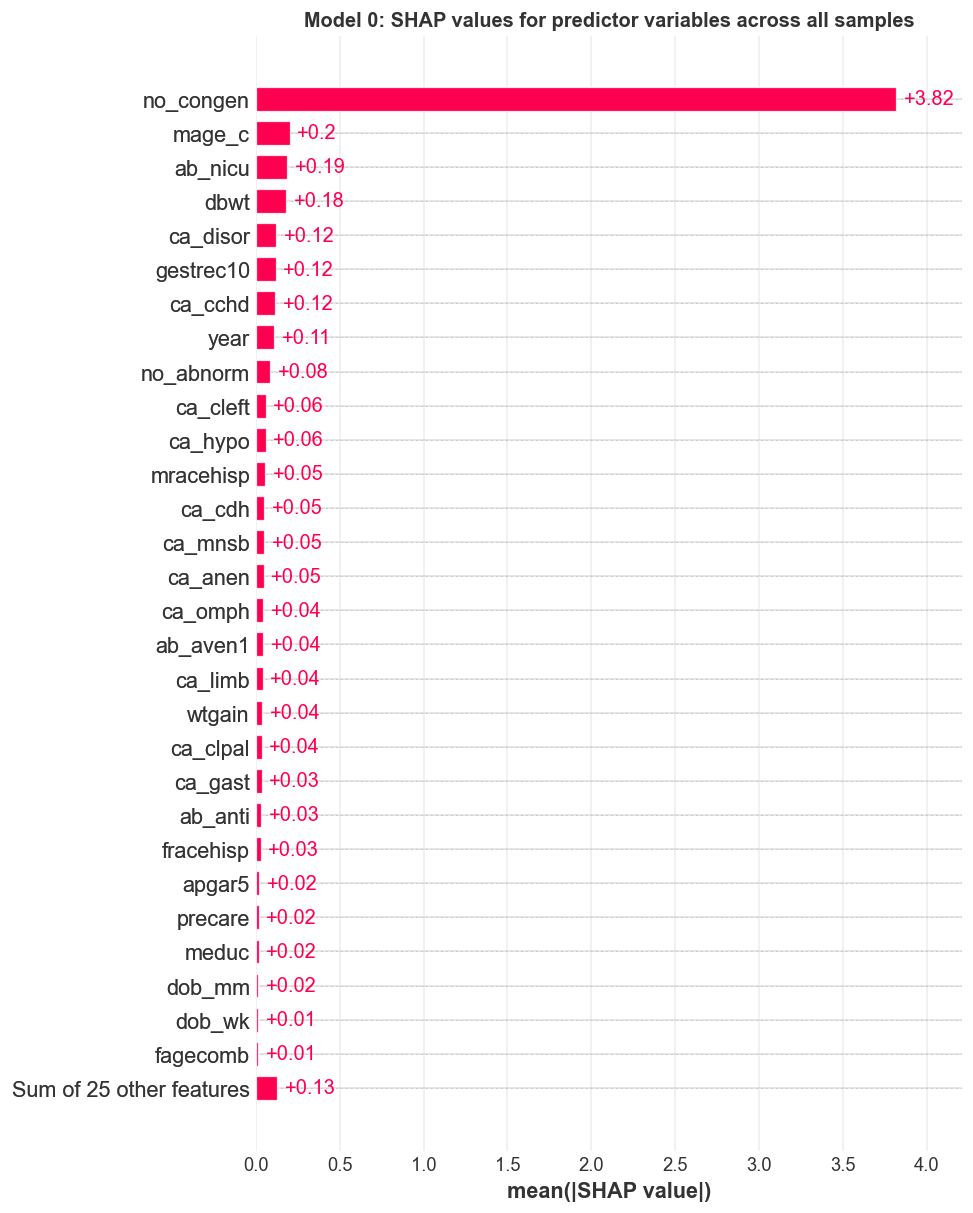

In [ ]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure(figsize=(8, 10))
    ax = plot.subplots()
    ax.set_title(f"Model 0: SHAP values for predictor variables across all samples")
    shap.plots.bar(explanation, max_display=30, ax=ax)  # clustering=clustering_0,

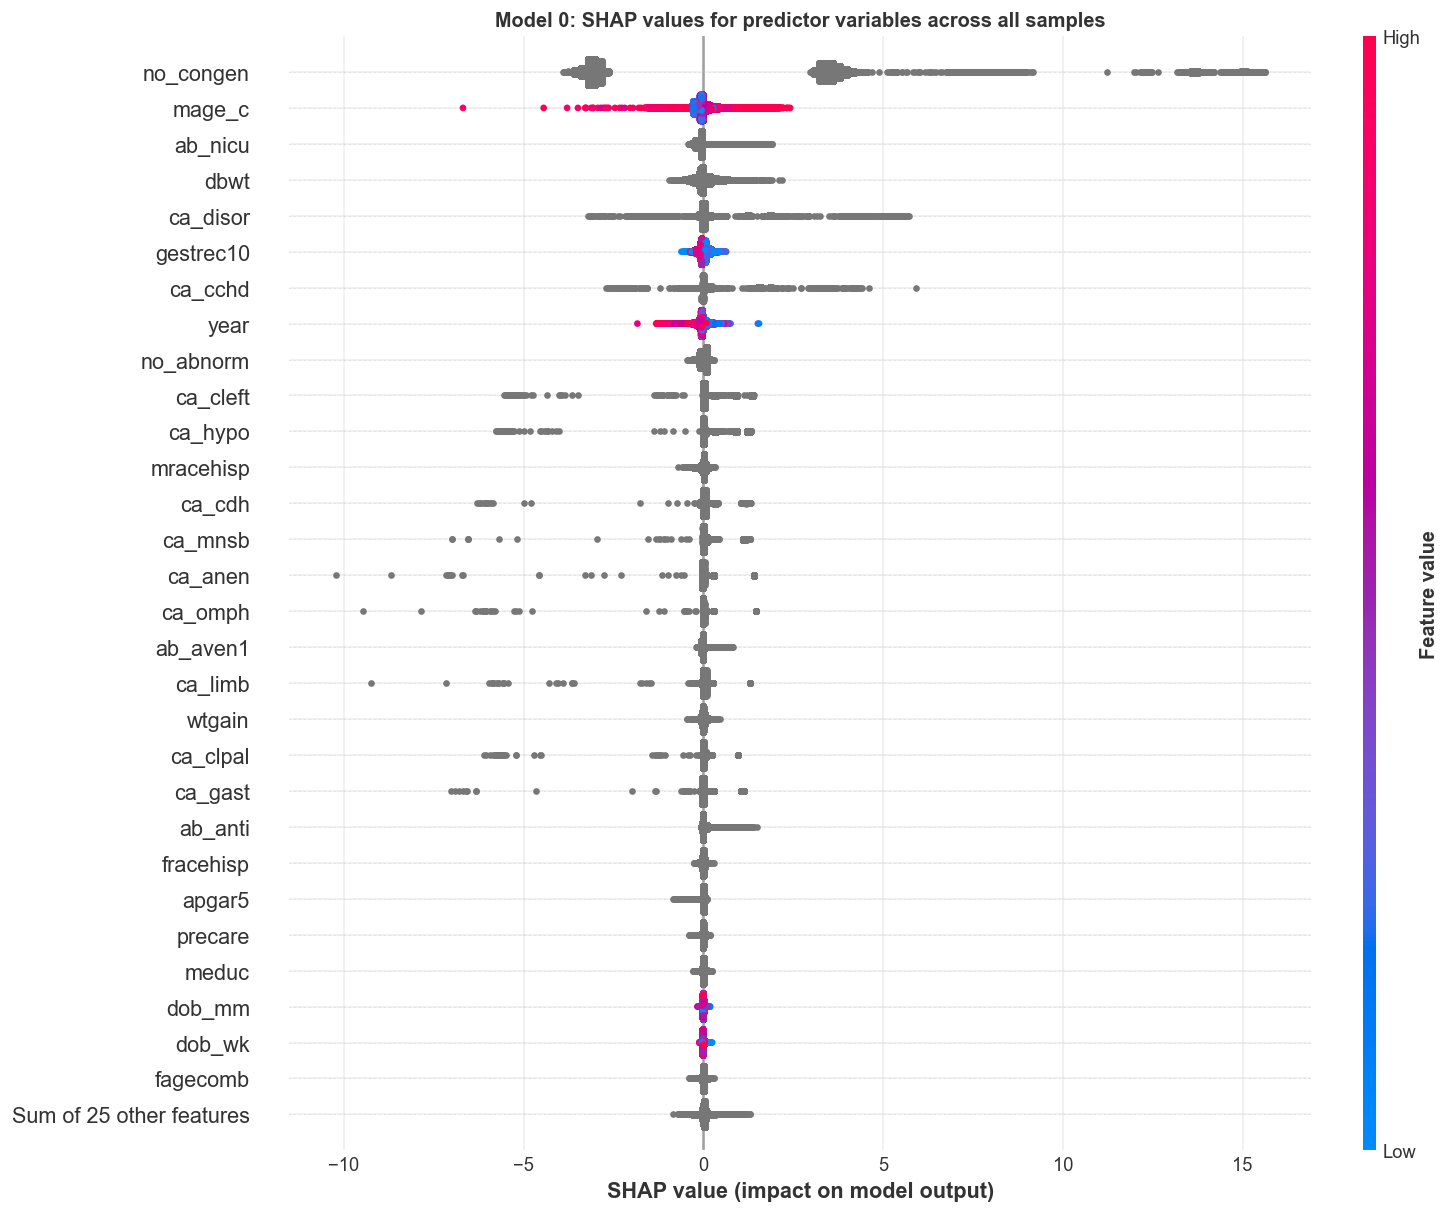

In [ ]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure()
    ax = plot.subplots()
    ax.set_title(
        f"Model {model_idx}: SHAP values for predictor variables across all samples"
    )
    shap.plots.beeswarm(explanation, max_display=30, plot_size=(8, 10))

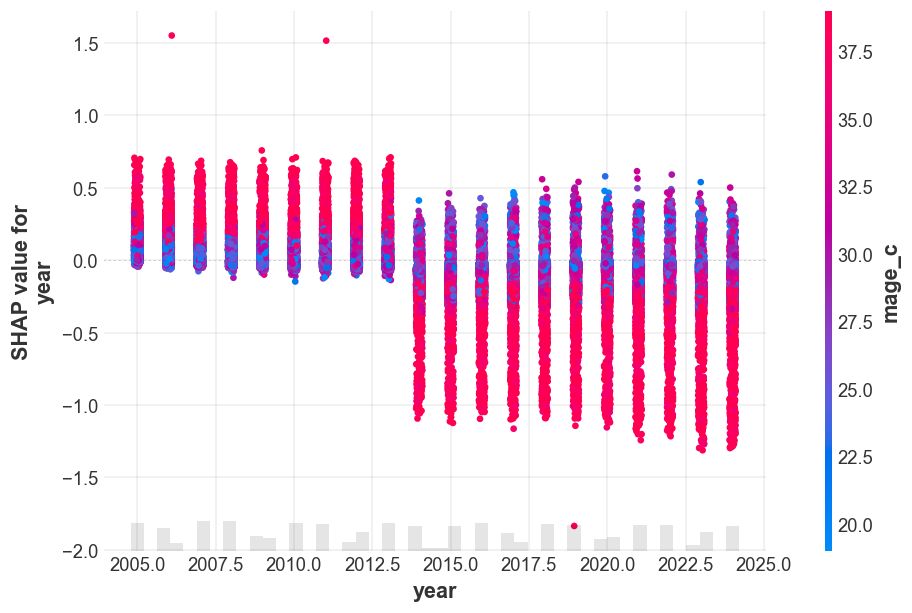

In [ ]:
shap.plots.scatter(explanation[:, "year"], color=explanation[:, "mage_c"])

## Model 1


In [62]:
features_to_remove_0 = [
    "fracehisp",  # correlated with mracehisp, keep mracehisp
    "fagecomb",  # correlated with mage_c, keep mage_c
    "pwgt_r",  # correlated with bmi, keep bmi
    "ab_aven6",  # correlated with ab_aven1, keep ab_aven
    "feduc",  # low signal
    "ld_indl",  # low signal
    "ab_surf",  # low signal
    "sex",  # low signal
    "rf_phype",  # low signal
    "ab_seiz",  # low signal
    "rf_ghype",  # low signal
    "rf_gdiab",  # low signal
    "wic",  # low signal, correlated with pay_rec, meduc, feduc
    "rf_pdiab",  # low signal
    "rf_inftr",  # low signal
    "rf_ppterm",  # low signal
    "rf_fedrg",  # low signal
    "rf_artec",  # low signal
    "apgar10",  # low signal, we keep apgar5
    "no_risks",  # low signal
    "dob_mm",  # low signal
    "dob_wk",  # low signal
]

X_1 = X.drop(columns=features_to_remove_0)

X_train = X_train.drop(columns=features_to_remove_0)

X_valid = X_valid.drop(columns=features_to_remove_0)

features = X_1.columns.to_list()
categorical = [col for col in categorical if col not in features_to_remove_0]

train_data = lgb.Dataset(
    X_train, label=y_train, categorical_feature=categorical, free_raw_data=False
)

valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=categorical,
    reference=train_data,
    free_raw_data=False,
)

model_idx = 1
model_name = (
    f"Model {model_idx} (after removing {len(features_to_remove_0)} predictors)"
)

print(f"Features removed: {features_to_remove_0}")
print(f"Features remaining: {X_1.columns.to_list()}")
print(f"Number of features in {model_name}: {X_1.shape[1]} (down from {X.shape[1]})")

Features removed: ['fracehisp', 'fagecomb', 'pwgt_r', 'ab_aven6', 'feduc', 'ld_indl', 'ab_surf', 'rf_phype', 'ab_seiz', 'rf_ghype', 'rf_gdiab', 'wic', 'rf_pdiab', 'rf_inftr', 'rf_ppterm', 'rf_fedrg', 'rf_artec', 'apgar10', 'no_risks']
Features remaining: ['dob_mm', 'dob_wk', 'bfacil3', 'sex', 'precare', 'gestrec10', 'rf_ehype', 'ld_augm', 'me_pres', 'dmeth_rec', 'apgar5', 'ab_aven1', 'ab_nicu', 'ab_anti', 'no_abnorm', 'ca_anen', 'ca_mnsb', 'ca_cchd', 'ca_cdh', 'ca_omph', 'ca_gast', 'ca_limb', 'ca_cleft', 'ca_clpal', 'ca_hypo', 'ca_disor', 'no_congen', 'meduc', 'mracehisp', 'pay_rec', 'year', 'dbwt', 'wtgain', 'bmi', 'mage_c']
Number of features in Model 1 (after removing 19 predictors): 35 (down from 35)


In [63]:
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=NUM_BOOST_ROUND,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[
        early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
        log_evaluation(period=10),
    ],
)

[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 813
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 50 rounds
[10]	train's average_precision: 0.541575	train's binary_logloss: 0.00234372	valid's average_precision: 0.535698	valid's binary_logloss: 0.00236183
[20]	train's average_precision: 0.545229	train's binary_logloss: 0.00220779	valid's average_precision: 0.53918	valid's binary_logloss: 0.0022285
[30]	train's average_precision: 0.547156	train's binary_logloss: 0.00212114	valid's average_precision: 0.540855	valid's binary_logloss: 0.0021444
[40]	train's average_precision: 0.548415	train's binary_logloss: 0.00205861	valid's average_precision: 0.541679	valid's binary_logloss: 0.00208424
[50]	train's aver

In [64]:
best_iter = gbm.best_iteration
gbm.save_model(
    f"{OUTPUT_DIR}/model_{model_idx}_{datetime.now().strftime("%Y%m%d%H%M")}.txt",
    num_iteration=best_iter,
)
print("best_iteration:", best_iter)

best_iteration: 480


In [65]:
p_valid_1 = gbm.predict(X_valid, num_iteration=best_iter)

In [70]:
p_valid_auc = roc_auc_score(y_valid, p_valid_1)
p_valid_ap = average_precision_score(y_valid, p_valid_1)
p_valid_ll = log_loss(y_valid, p_valid_1, labels=[0, 1])
p_valid_fpr, p_valid_tpr, p_valid_thresholds = roc_curve(y_valid, p_valid_1)

# Top-K precision (what fraction of the top K are truly positive?)
order = np.argsort(-p_valid_1)
y_sorted = y_valid.to_numpy()[order]

K = 10000
precision_at_k = y_sorted[:K].mean()
recall_at_k = y_sorted[:K].sum() / y_valid.sum()
precision_at_k, recall_at_k

# Precision/recall at a chosen threshold
thr = 0.01
y_hat = (p_valid_1 >= thr).astype(int)
prec, rec, f1, _ = precision_recall_fscore_support(y_valid, y_hat, average="binary")
prec, rec, f1

print(f"Validation AUC:      {p_valid_auc:.4f}")
print(f"Validation AP:       {p_valid_ap:.6f}")
print(f"Validation log loss: {p_valid_ll:.6f}")

print(f"Precision at {K}: {precision_at_k}")
print(f"Recall at {K}: {recall_at_k}")
print(f"Precision (threshold={thr}): {prec}")
print(f"Recall (threshold={thr}): {rec}")

Validation AUC:      0.9651
Validation AP:       0.554016
Validation log loss: 0.001845
Precision at 10000: 0.5295
Recall at 10000: 0.5330179182605195
Precision (threshold=0.01): 0.13047606989111168
Recall (threshold=0.01): 0.6224078920877794


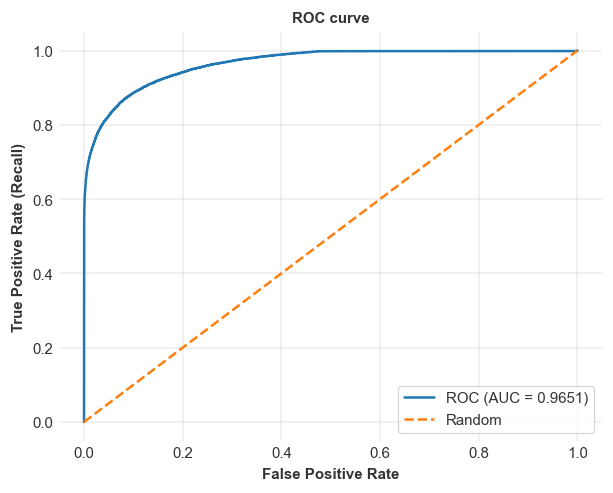

In [71]:
plt.figure(figsize=(5, 4))
plt.plot(p_valid_fpr, p_valid_tpr, label=f"ROC (AUC = {p_valid_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC curve")
plt.legend()
plt.show()

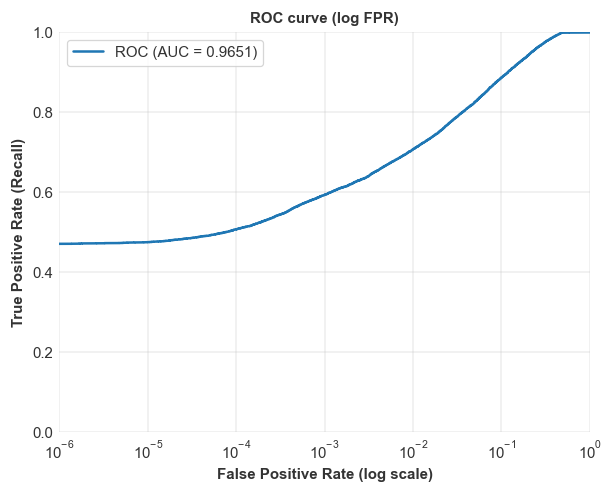

In [72]:
plt.figure(figsize=(5, 4))
plt.plot(p_valid_fpr, p_valid_tpr, label=f"ROC (AUC = {p_valid_auc:.4f})")
plt.xscale("log")
plt.xlim(1e-6, 1)  # adjust lower bound as needed
plt.ylim(0, 1)

plt.xlabel("False Positive Rate (log scale)")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC curve (log FPR)")
plt.legend()
plt.show()

In [73]:
importance_gain = gbm.feature_importance(importance_type="gain")

df_imp_gain = pd.DataFrame(
    {"feature": features, "importance_gain": importance_gain}
).sort_values("importance_gain", ascending=False)

df_imp_gain.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_feature_importance_gain_{datetime.now().strftime("%Y%m%d%H%M")}.csv",
    index=False,
)
df_imp_gain

,feature,importance_gain
34,mage_c,4.407475e+06
26,no_congen,3.432554e+06
30,year,1.105790e+06
17,ca_cchd,9.259713e+05
25,ca_disor,7.758215e+05
22,ca_cleft,6.281605e+05
24,ca_hypo,5.416198e+05
19,ca_omph,4.335631e+05
21,ca_limb,4.298541e+05
18,ca_cdh,4.201250e+05


In [74]:
X_eval = X_valid.loc[eval_idx].astype(np.float64).replace({pd.NA: np.nan})
X_eval[categorical] = X_eval[categorical].astype("category")


model_wrapped = LGBMWrapper(gbm)

In [75]:
result = permutation_importance(
    model_wrapped,
    X_eval,
    y_eval,
    scoring=ap_scorer,
    n_repeats=10,
    n_jobs=NUM_THREADS,
    random_state=RANDOM_SEED,
)

perm_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std,
    }
).sort_values("importance_mean", ascending=False)

perm_importance.to_csv(
    f"{OUTPUT_DIR}/permutation_importance_{datetime.now().strftime("%Y%m%d%H%M")}.csv",
    index=False,
)
perm_importance

,feature,importance_mean,importance_std
26,no_congen,0.702085,0.001249
34,mage_c,0.051405,0.001173
12,ab_nicu,0.051049,0.000413
25,ca_disor,0.023329,0.000625
24,ca_hypo,0.022552,0.000880
22,ca_cleft,0.020860,0.000739
31,dbwt,0.019627,0.000673
18,ca_cdh,0.017797,0.000786
17,ca_cchd,0.017582,0.000744
19,ca_omph,0.014715,0.000775


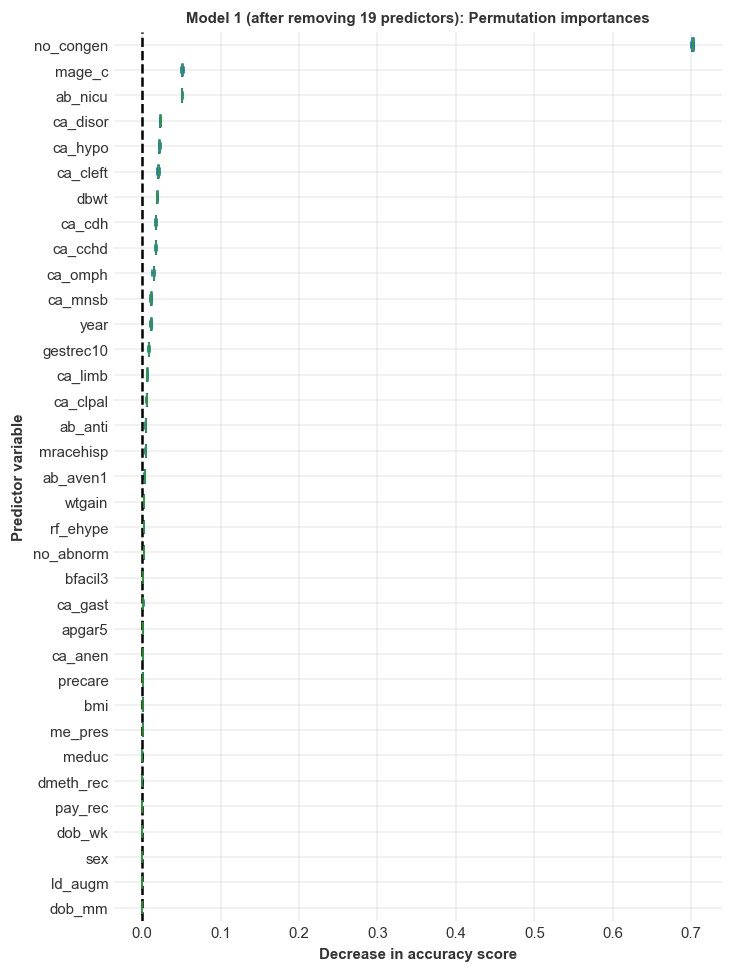

In [77]:
sorted_importances_idx_0 = result.importances_mean.argsort()

importances_0 = pd.DataFrame(
    result.importances[sorted_importances_idx_0].T,
    columns=X_eval.columns[sorted_importances_idx_0],
)

ax = importances_0.plot.box(vert=False, whis=10, figsize=(6, 8))
ax.set_title(f"{model_name}: Permutation importances")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.set_ylabel("Predictor variable")
plt.show()

In [78]:
X_eval.columns[sorted_importances_idx_0]

Index(['dob_mm', 'ld_augm', 'sex', 'dob_wk', 'pay_rec', 'dmeth_rec', 'meduc',
       'me_pres', 'bmi', 'precare', 'ca_anen', 'apgar5', 'ca_gast', 'bfacil3',
       'no_abnorm', 'rf_ehype', 'wtgain', 'ab_aven1', 'mracehisp', 'ab_anti',
       'ca_clpal', 'ca_limb', 'gestrec10', 'year', 'ca_mnsb', 'ca_omph',
       'ca_cchd', 'ca_cdh', 'dbwt', 'ca_cleft', 'ca_hypo', 'ca_disor',
       'ab_nicu', 'mage_c', 'no_congen'],
      dtype='object')

In [79]:
# need not NA - some columns have many NAs
distance_0, corr_0 = stats_utils.distance_corr_dissimilarity(X_eval)
condensed_0 = squareform(distance_0, checks=True)
dist_linkage_0 = hierarchy.ward(condensed_0)

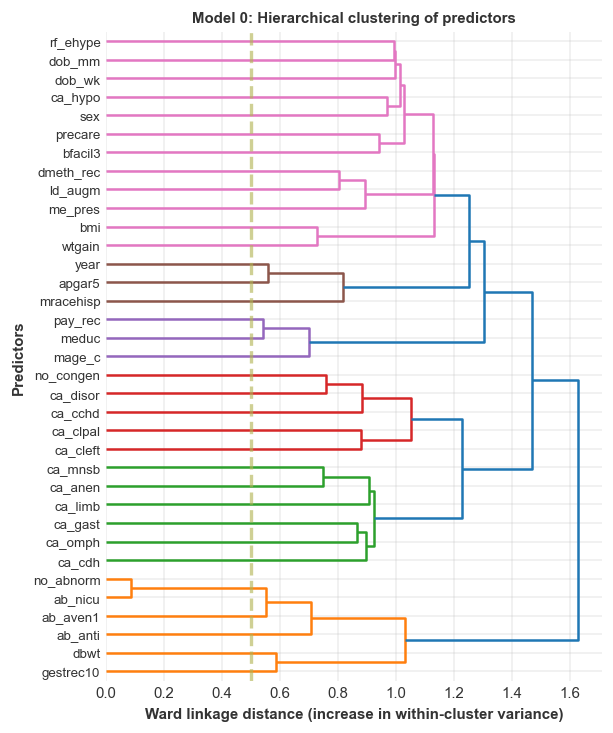

In [80]:
plt.figure(figsize=(5, 6))
dendro_0 = hierarchy.dendrogram(
    dist_linkage_0, labels=X_eval.columns.to_list(), orientation="right", ax=plt.axes()
)
plt.vlines(0.5, 0, 500, linestyle="--", color="#b2b4549f", linewidth=2)
plt.xlabel("Ward linkage distance (increase in within-cluster variance)")
plt.ylabel("Predictors")
plt.title(f"Model {model_idx}: Hierarchical clustering of predictors")
plt.show()

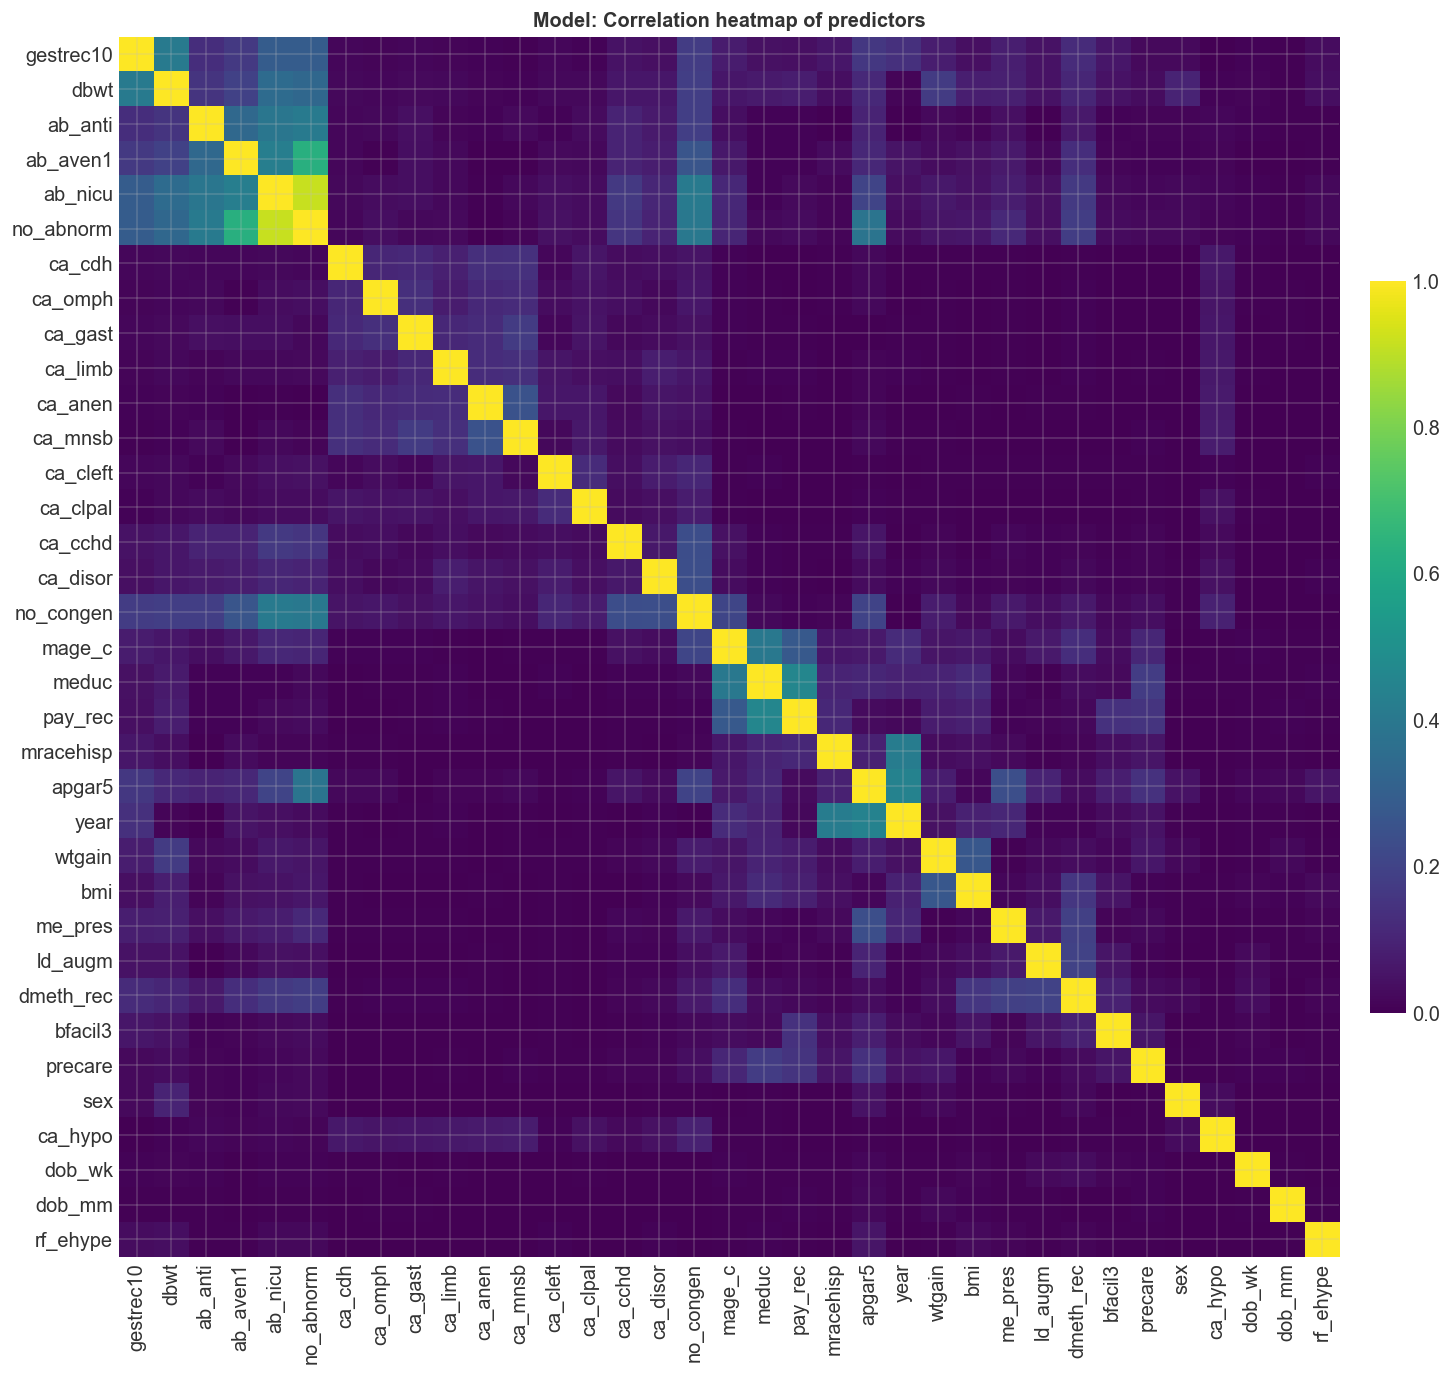

In [ ]:
dendro_0_idx = np.arange(0, len(dendro_0["ivl"]))

with plt.rc_context(
    {"ytick.labelsize": 12, "xtick.labelsize": 12, "axes.titlesize": 12}
):
    plt.figure(figsize=(10, 10))
    plt.set_cmap("viridis")
    ax = plt.axes()
    im = ax.imshow(corr_0[dendro_0["leaves"], :][:, dendro_0["leaves"]])
    ax.set_title(f"Model: Correlation heatmap of predictors")
    ax.set_xticks(dendro_0_idx)
    ax.set_yticks(dendro_0_idx)
    ax.set_xticklabels(dendro_0["ivl"], rotation="vertical")
    ax.set_yticklabels(dendro_0["ivl"])
    plt.colorbar(im, ax=ax, fraction=0.03, pad=0.025)
    plt.show()

In [82]:
# Tell SHAP this is a LightGBM model
explainer = shap.TreeExplainer(gbm)
explanation = explainer(X_eval)
clustering_0 = shap.utils.hclust(
    X_eval, y_eval, linkage="average", random_state=RANDOM_SEED
)
shap_values = explanation.values

# Handle both cases: list or array
if isinstance(shap_values, list):
    shap_pos = shap_values[1]  # SHAP values for positive class
else:
    shap_pos = shap_values  # already positive class

# Global importance: mean |SHAP|
shap_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "mean_abs_shap": np.mean(np.abs(shap_pos), axis=0),
    }
).sort_values("mean_abs_shap", ascending=False)

shap_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_shap_importance_{datetime.now().strftime("%Y%m%d%H%M")}.csv",
    index=False,
)
shap_importance

c:\Users\FrankBuckley\miniconda3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 0 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
c:\Users\FrankBuckley\miniconda3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 1 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
c:\Users\FrankBuckley\miniconda3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 2 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
c:\Users\FrankBuckley\

,feature,mean_abs_shap
26,no_congen,3.952111
34,mage_c,0.242308
31,dbwt,0.178484
12,ab_nicu,0.158108
14,no_abnorm,0.126258
5,gestrec10,0.122917
25,ca_disor,0.099453
17,ca_cchd,0.095606
30,year,0.080093
28,mracehisp,0.070495


In [84]:
shap_importance["feature"].tolist()

['no_congen',
 'mage_c',
 'dbwt',
 'ab_nicu',
 'no_abnorm',
 'gestrec10',
 'ca_disor',
 'ca_cchd',
 'year',
 'mracehisp',
 'ca_cleft',
 'ca_hypo',
 'ab_aven1',
 'rf_ehype',
 'wtgain',
 'ab_anti',
 'ca_cdh',
 'ca_clpal',
 'ca_omph',
 'ca_mnsb',
 'ca_limb',
 'precare',
 'apgar5',
 'bmi',
 'meduc',
 'dob_mm',
 'dob_wk',
 'pay_rec',
 'ca_gast',
 'dmeth_rec',
 'ca_anen',
 'me_pres',
 'ld_augm',
 'bfacil3',
 'sex']

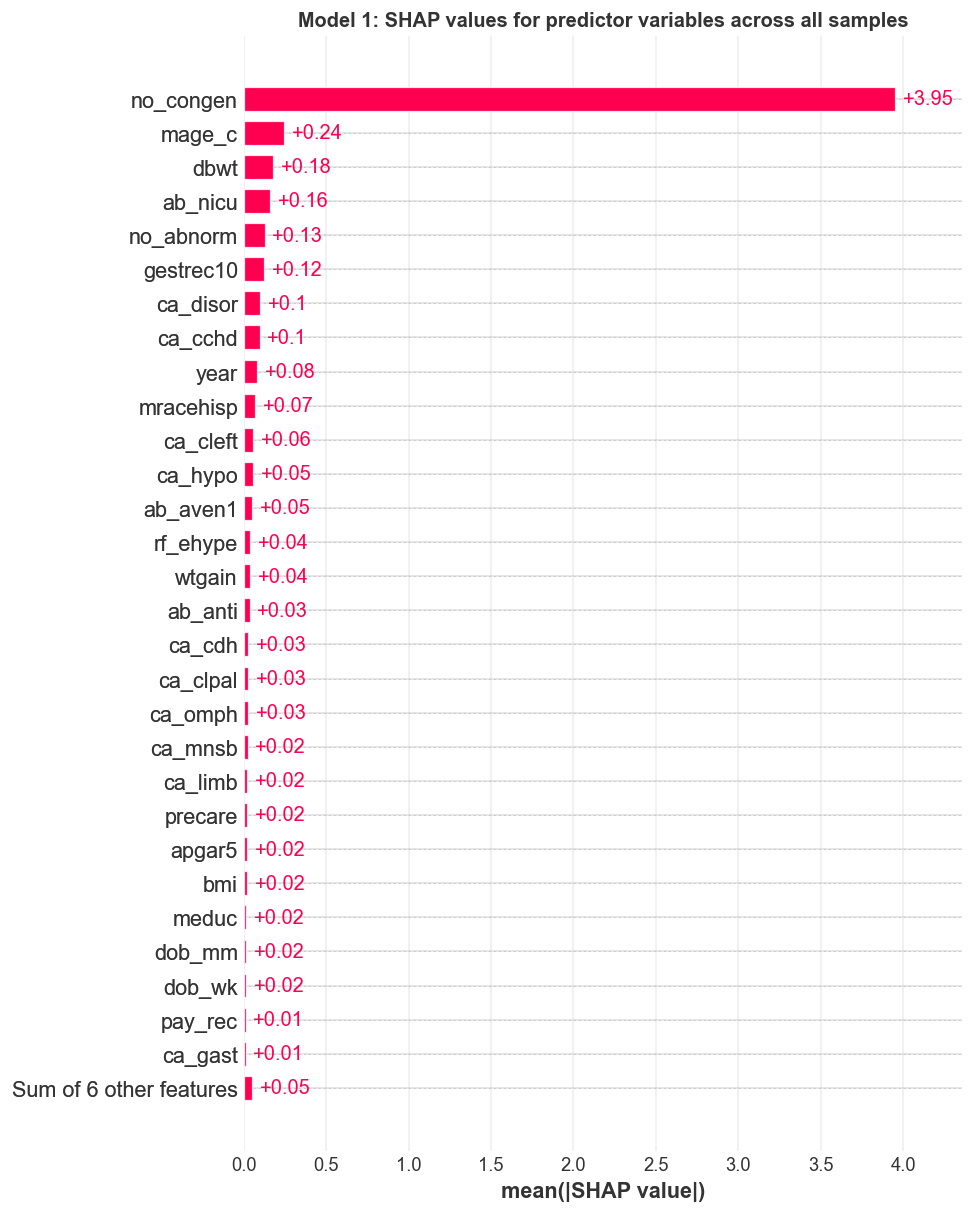

In [ ]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure(figsize=(8, 10))
    ax = plot.subplots()
    ax.set_title(
        f"Model {model_idx}: SHAP values for predictor variables across all samples"
    )
    shap.plots.bar(explanation, max_display=30, ax=ax)  # clustering=clustering_0,

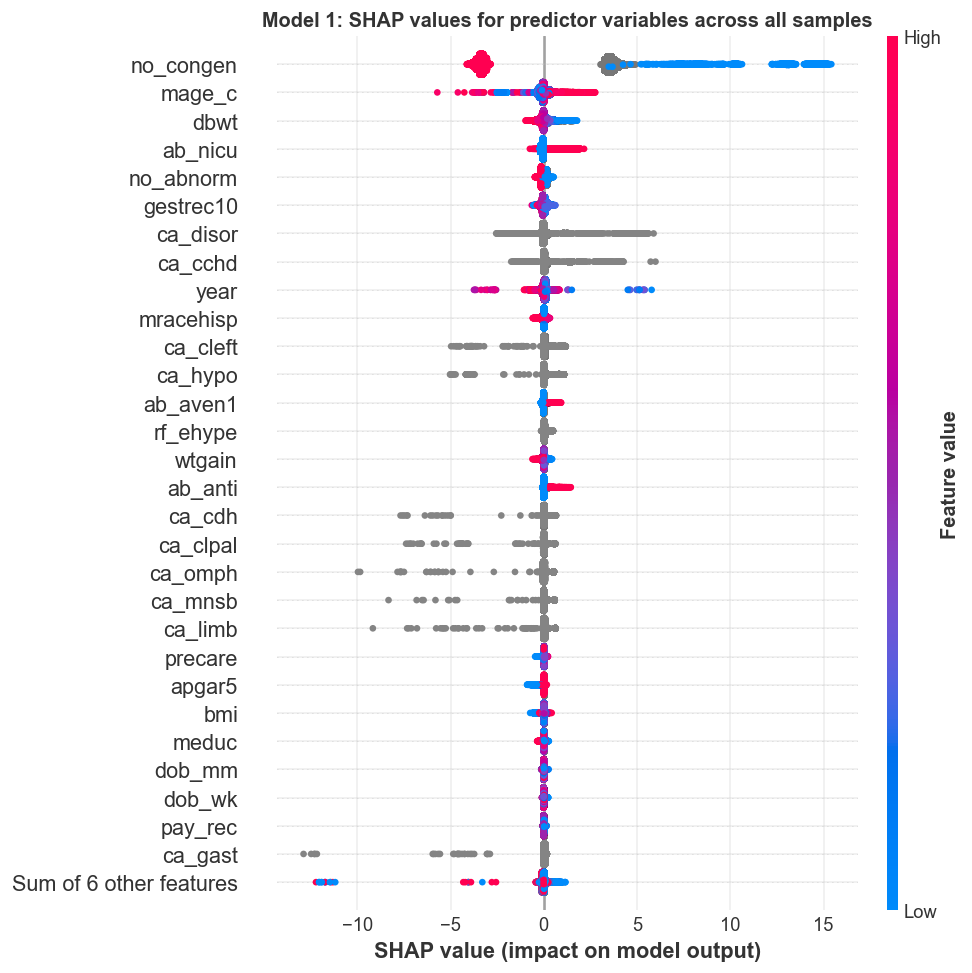

In [ ]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure()
    ax = plot.subplots()
    ax.set_title(
        f"Model {model_idx}: SHAP values for predictor variables across all samples"
    )
    shap.plots.beeswarm(explanation, max_display=30, plot_size=(8, 8))

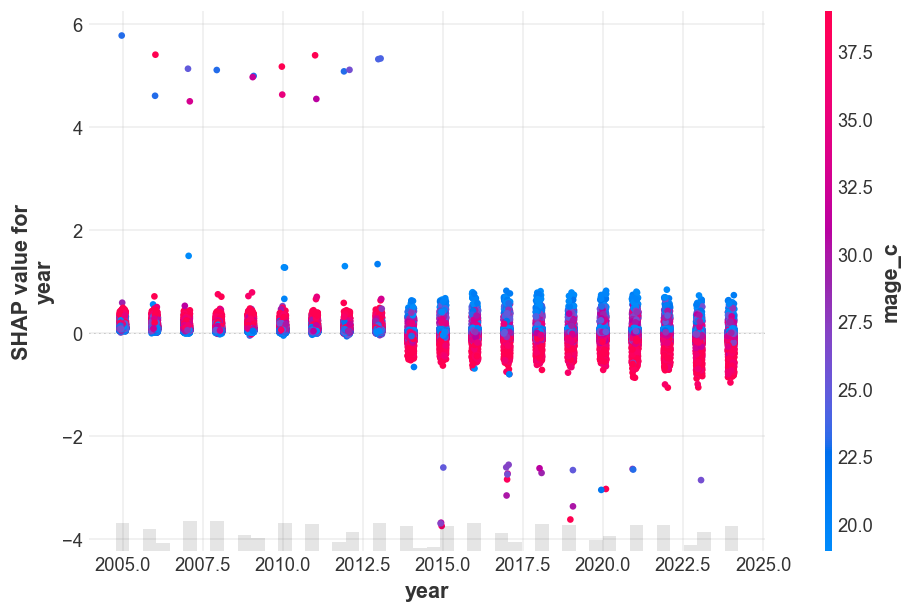

In [88]:
shap.plots.scatter(explanation[:, "year"], color=explanation[:, "mage_c"])

## Model 2


In [93]:
features_to_remove_1 = [
    "wtgain",  # correlated with bmi
    "meduc",  # low signal
    "dob_mm",  # low signal
    "dob_wk",  # low signal
    "pay_rec",  # low signal
    "ca_gast",  # low signal
    "dmeth_rec",  # low signal
    "ca_anen",  # low signal
    "me_pres",  # low signal
    "ld_augm",  # low signal
    "bfacil3",  # low signal
    "sex",  # low signal
]

X_2 = X_1.drop(columns=features_to_remove_1)

X_train = X_train.drop(columns=features_to_remove_1)

X_valid = X_valid.drop(columns=features_to_remove_1)

features = X_2.columns.to_list()
categorical = [col for col in categorical if col not in features_to_remove_1]

train_data = lgb.Dataset(
    X_train, label=y_train, categorical_feature=categorical, free_raw_data=False
)

valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=categorical,
    reference=train_data,
    free_raw_data=False,
)

model_idx = 2
model_name = (
    f"Model {model_idx} (after removing {len(features_to_remove_1)} predictors)"
)

print(f"Features removed: {features_to_remove_1}")
print(f"Features remaining: {X_2.columns.to_list()}")
print(f"Number of features in {model_name}: {X_2.shape[1]} (down from {X.shape[1]})")

Features removed: ['wtgain', 'meduc', 'dob_mm', 'dob_wk', 'pay_rec', 'ca_gast', 'dmeth_rec', 'ca_anen', 'me_pres', 'ld_augm', 'bfacil3', 'sex']
Features remaining: ['precare', 'gestrec10', 'rf_ehype', 'apgar5', 'ab_aven1', 'ab_nicu', 'ab_anti', 'no_abnorm', 'ca_mnsb', 'ca_cchd', 'ca_cdh', 'ca_omph', 'ca_limb', 'ca_cleft', 'ca_clpal', 'ca_hypo', 'ca_disor', 'no_congen', 'mracehisp', 'year', 'dbwt', 'bmi', 'mage_c']
Number of features in Model 2 (after removing 12 predictors): 23 (down from 54)


In [94]:
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=NUM_BOOST_ROUND,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[
        early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
        log_evaluation(period=10),
    ],
)

[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 50 rounds
[10]	train's average_precision: 0.416581	train's binary_logloss: 0.00283256	valid's average_precision: 0.407159	valid's binary_logloss: 0.00284383
[20]	train's average_precision: 0.450649	train's binary_logloss: 0.00257612	valid's average_precision: 0.439773	valid's binary_logloss: 0.00259301
[30]	train's average_precision: 0.469638	train's binary_logloss: 0.00242356	valid's average_precision: 0.459093	valid's binary_logloss: 0.00244425
[40]	train's average_precision: 0.476076	train's binary_logloss: 0.0023221	valid's average_precision: 0.466442	valid's binary_logloss: 0.00234563
[50]	train's av

In [95]:
best_iter = gbm.best_iteration
gbm.save_model(
    f"{OUTPUT_DIR}/model_{model_idx}_{datetime.now().strftime("%Y%m%d%H%M")}.txt",
    num_iteration=best_iter,
)
print("best_iteration:", best_iter)

best_iteration: 354


In [96]:
p_valid_1 = gbm.predict(X_valid, num_iteration=best_iter)

In [98]:
metrics_df, p_valid_fpr, p_valid_tpr, p_valid_thresholds = get_metrics(y_valid, p_valid_1, K=10000, thr=0.01)

metrics_df.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_validation_metrics_{datetime.now().strftime("%Y%m%d%H%M")}.csv",
    index=False,
)

metrics_df

,metric,value
0,Validation AUC,0.964472
1,Validation AP,0.491626
2,Validation log loss,0.002021
3,Precision at 10000,0.501400
4,Recall at 10000,0.504731
5,Precision (threshold=0.01),0.129442
6,Recall (threshold=0.01),0.614858


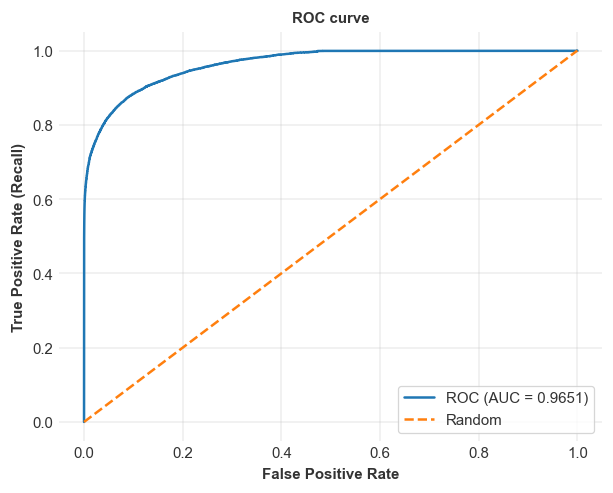

In [99]:
plt.figure(figsize=(5, 4))
plt.plot(p_valid_fpr, p_valid_tpr, label=f"ROC (AUC = {p_valid_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC curve")
plt.legend()
plt.show()

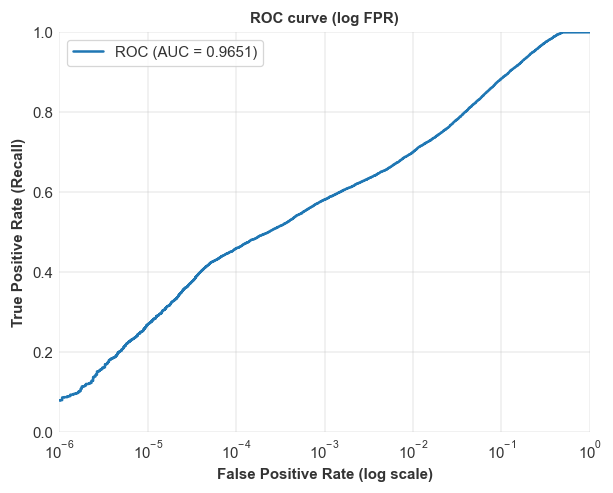

In [100]:
plt.figure(figsize=(5, 4))
plt.plot(p_valid_fpr, p_valid_tpr, label=f"ROC (AUC = {p_valid_auc:.4f})")
plt.xscale("log")
plt.xlim(1e-6, 1)  # adjust lower bound as needed
plt.ylim(0, 1)

plt.xlabel("False Positive Rate (log scale)")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC curve (log FPR)")
plt.legend()
plt.show()

In [102]:
features

['dob_mm',
 'dob_wk',
 'bfacil3',
 'sex',
 'precare',
 'gestrec10',
 'rf_ehype',
 'ld_augm',
 'me_pres',
 'dmeth_rec',
 'apgar5',
 'ab_aven1',
 'ab_nicu',
 'ab_anti',
 'no_abnorm',
 'ca_anen',
 'ca_mnsb',
 'ca_cchd',
 'ca_cdh',
 'ca_omph',
 'ca_gast',
 'ca_limb',
 'ca_cleft',
 'ca_clpal',
 'ca_hypo',
 'ca_disor',
 'no_congen',
 'meduc',
 'mracehisp',
 'pay_rec',
 'year',
 'dbwt',
 'wtgain',
 'bmi',
 'mage_c']

In [104]:
importance_gain = gbm.feature_importance(importance_type="gain")

df_imp_gain = pd.DataFrame(
    {"feature": features, "importance_gain": importance_gain}
).sort_values("importance_gain", ascending=False)

df_imp_gain.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_feature_importance_gain_{datetime.now().strftime("%Y%m%d%H%M")}.csv",
    index=False,
)
df_imp_gain

,feature,importance_gain
17,no_congen,3.758702e+06
22,mage_c,2.007843e+06
16,ca_disor,1.284138e+06
9,ca_cchd,9.391007e+05
13,ca_cleft,6.407655e+05
20,dbwt,6.073343e+05
15,ca_hypo,5.605655e+05
14,ca_clpal,4.306625e+05
12,ca_limb,2.560128e+05
19,year,2.477407e+05


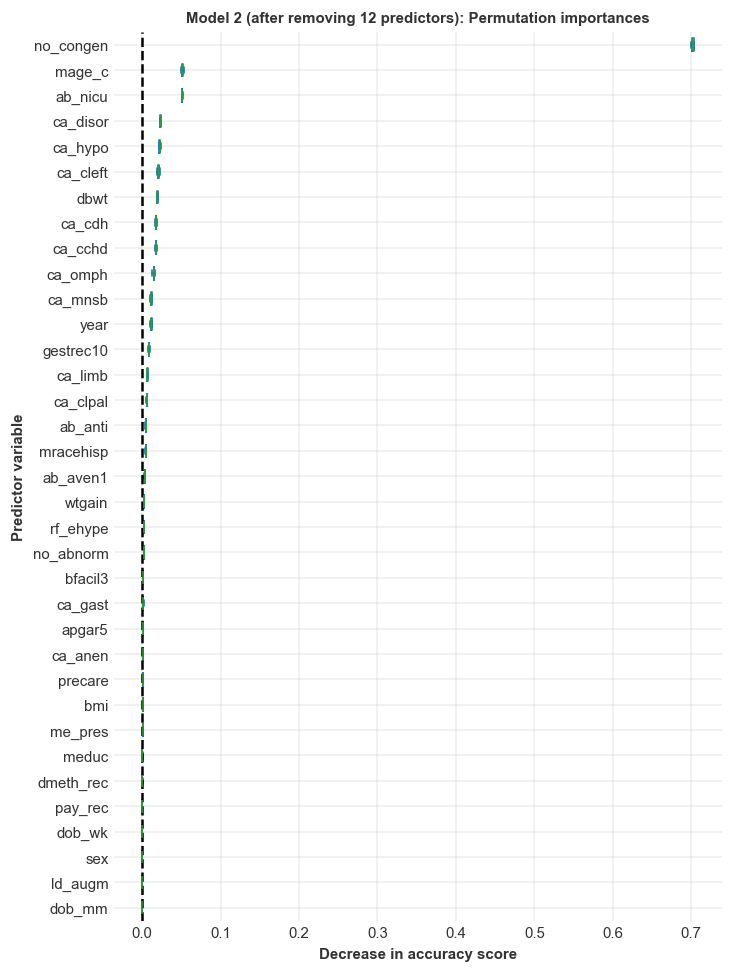

In [105]:
sorted_importances_idx_0 = result.importances_mean.argsort()

importances_0 = pd.DataFrame(
    result.importances[sorted_importances_idx_0].T,
    columns=X_eval.columns[sorted_importances_idx_0],
)

ax = importances_0.plot.box(vert=False, whis=10, figsize=(6, 8))
ax.set_title(f"{model_name}: Permutation importances")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.set_ylabel("Predictor variable")
plt.show()

## Calibration


In [83]:
p_cal_raw = gbm.predict(X_cal, num_iteration=gbm.best_iteration, raw_score=True)

ValueError: train and valid dataset categorical_feature do not match.

In [ ]:
calibrator = LogisticRegression(solver="lbfgs", max_iter=1000)
calibrator.fit(p_cal_raw.reshape(-1, 1), y_cal)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [ ]:
def predict_proba_calibrated(gbm, calibrator, X_new, num_iteration=None):
    p_raw = gbm.predict(X_new, num_iteration=num_iteration, raw_score=True)
    return calibrator.predict_proba(p_raw.reshape(-1, 1))[:, 1]

## Prediction


In [ ]:
p_valid_cal = predict_proba_calibrated(
    gbm, calibrator, X_valid, num_iteration=gbm.best_iteration
)
p_valid_raw = gbm.predict(X_valid, num_iteration=gbm.best_iteration)

print("Raw logloss:", log_loss(y_valid, p_valid_raw, labels=[0, 1]))
print("Cal logloss:", log_loss(y_valid, p_valid_cal, labels=[0, 1]))
print("Raw brier:  ", brier_score_loss(y_valid, p_valid_raw))
print("Cal brier:  ", brier_score_loss(y_valid, p_valid_cal))

Raw logloss: 0.0018285602617651813
Cal logloss: 0.0018293342206871378
Raw brier:   0.00026302694649834343
Cal brier:   0.0002630088341044558
